In [1]:
import pandas as pd

In [2]:
from scipy.sparse import coo_matrix
import h5py
import logging
import numpy as np
import pandas as pd

def parse_go_hd5(filename):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        df = pd.DataFrame(coo.toarray(),  index=columns, columns = row )
        duplicates = df.index.duplicated(keep='first')
        df = df.loc[~duplicates, :]
    return df

def parse_expression_hd5_lee(filename):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                row_uid.append(x_o)
            except KeyError:
                counter = counter + 1
                row_uid.append('del')
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    duplicates = df.index.duplicated(keep='first')
    df = df.loc[~duplicates, ~duplicates]


    return df 

In [111]:
row = np.array([0, 1, 2, 0])
col = np.array([0, 1, 1, 0])
data = np.array([1, 2, 4, 8])
sparse.csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[9, 0, 0],
       [0, 2, 0],
       [0, 4, 0]])

In [115]:
hic_mat = sparse.csr_matrix((data, (row, col)), shape=(3, 3))


In [117]:
last_idx = hic_mat.shape[0] - 1

In [124]:
        nonzero_diag = hic_mat.nonzero()[0][hic_mat.nonzero()[0] == hic_mat.nonzero()[1]]
        

In [125]:
nonzero_diag

array([0, 1], dtype=int32)

In [123]:
nonzero_diag = list(set(nonzero_diag) - set(np.array([last_idx])) - set(np.array([0])))

In [122]:
set(nonzero_diag)

{1}

In [114]:
arr.nonzero()

(array([0, 1, 2], dtype=int32), array([0, 1, 1], dtype=int32))

In [930]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=10000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [4]:
go_df = parse_go_hd5("/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_gene2go.hdf5")

In [5]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

In [10]:
SRP_name='aggregates'
resolution='10kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

jac_sim = hm.hiCMatrix(exp_file_path)




In [11]:
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_jac_corr = pd.DataFrame(np.fill_diagonal(jac_sim.matrix.toarray(), jac_sim.matrix.max()) ,  index=all_genes, columns = all_genes)


In [45]:
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [324]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/hic_gene_gw_KR_KR.h5'

jac_dist = hm.hiCMatrix(exp_file_path)


In [938]:
all_genes = [x[3].decode() for x in jac_dist.cut_intervals]
df_dist_corr = pd.DataFrame(jac_dist.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [945]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [1035]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_dist.h5'

jac_dist = hm.hiCMatrix(exp_file_path)

In [1036]:
all_genes = [x[3].decode() for x in jac_dist.cut_intervals]
df_dist_corr = pd.DataFrame(jac_dist.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [940]:
df_dist_corr 

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972              0.0          17702.0           5568.0   
ENSG00000227232          17702.0              0.0          12134.0   
ENSG00000278267           5568.0          12134.0              0.0   
ENSG00000243485          17685.0             17.0          12117.0   
ENSG00000284332          18497.0            795.0          12929.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972          17685.0          18497.0          24213.0   
ENSG00000227232             17.0            795.0           6511.0   
ENSG00000278267          12117.0          12929.0          18645.0   
ENSG00000243485              0.0            812.0           6528.0   
ENSG00000284332            812.0              0.0           5716.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972          40604.0          45729.0          53550.0   
ENSG00000227232          22902.0          28027.0          35848.0   
ENSG00000278267          35036.0          40161.0          47982.0   
ENSG00000243485          22919.0          28044.0          35865.0   
ENSG00000284332          22107.0          27232.0          35053.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         121855.0  ...              0.0              0.0   
ENSG00000227232         104153.0  ...              0.0              0.0   
ENSG00000278267         116287.0  ...              0.0              0.0   
ENSG00000243485         104170.0  ...              0.0              0.0   
ENSG00000284332         103358.0  ...              0.0              0.0   
...                          ...  ...              ...              ...   
ENSG00000100312              0.0  ...         110022.0          68392.0   
ENSG00000254499              0.0  ...         115347.0          73717.0   
ENSG00000213683              0.0  ...         127261.0          85631.0   
ENSG00000184319              0.0  ...         128774.0          87144.0   
ENSG00000079974              0.0  ...         155490.0         113860.0   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972              0.0              0.0              0.0   
ENSG00000227232              0.0              0.0              0.0   
ENSG00000278267              0.0              0.0              0.0   
ENSG00000243485              0.0              0.0              0.0   
ENSG00000284332              0.0              0.0              0.0   
...                          ...              ...              ...   
ENSG00000100312          63781.0          46832.0             56.0   
ENSG00000254499          69106.0 

In [47]:
set(diag/1)

{24745.471034632115, 55409.81976502861, 55409.97130533649, 55410.54265398567}

In [48]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     55410.542654     55409.765056     55410.542654   
ENSG00000227232     55409.765056     55410.542654     55409.765092   
ENSG00000278267     55410.542654     55409.765092     55410.542654   
ENSG00000243485     33000.547085     53014.059257     33000.547085   
ENSG00000284332     29730.909756     30806.991076     29730.909756   
...                          ...              ...              ...   
ENSG00000100312     25559.415937     25188.882956     25559.415937   
ENSG00000254499     18976.471612     18908.408863     18976.471612   
ENSG00000213683      2874.608697      2893.388777      2874.608697   
ENSG00000184319     33809.399875     34690.246946     33809.399875   
ENSG00000079974     34732.843055     35761.283779     34732.843055   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     33000.547085     29730.909756     29730.909756   
ENSG00000227232     53014.059257     30806.991076     30806.991076   
ENSG00000278267     33000.547085     29730.909756     29730.909756   
ENSG00000243485     55409.971305     55409.740638     55409.740638   
ENSG00000284332     55409.740638     55410.542654     55410.542654   
...                          ...              ...              ...   
ENSG00000100312     21921.241550     20481.246188     20481.246188   
ENSG00000254499     17807.251800     16755.347431     16755.347431   
ENSG00000213683      3069.751737      3005.910316      3005.910316   
ENSG00000184319     21923.271002     18040.539036     18040.539036   
ENSG00000079974     23410.200529     19229.714903     19229.714903   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     36560.544197     35712.759461     34463.434237   
ENSG00000227232     37578.947492     36951.153083     35545.184413   
ENSG00000278267     36560.544197     35712.759461     34463.434237   
ENSG00000243485     29450.096939     27903.354884     26819.065664   
ENSG00000284332     25589.090442     23940.350228     23096.640748   
...                          ...              ...              ...   
ENSG00000100312     23050.988170     20730.184287     21284.288237   
ENSG00000254499     16073.187156     14716.574065     15205.092301   
ENSG00000213683      2800.575869      2686.427126      2695.345717   
ENSG00000184319     41136.809180     45904.931900     44044.685884   
ENSG00000079974     42085.540732     46002.948178     44273.762565   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     31977.483902  ...     37335.970556     33646.614725   
ENSG00000227232     33195.362969  ...     38629.878282     34795.043971   
ENSG00000278267     31977.483902  ...     37335.970556     33646.614725   
ENSG00000243485     23763.546832  ...     27320.402727     25485.716112   
ENSG00000284332     19819.880574  ...     22858.243029     21534.395310   
...                          ...  ...              ...              ...   
ENSG00000100312     18117.180876  ...     28759.341169     27263.337343   
ENSG00000254499     12942.101848  ...     19664.585073     19736.229548   
ENSG00000213683      2566.208000  ...      2648.033125      2787.245412   
ENSG00000184319     49638.153571  ...     52490.390058     46688.629433   
ENSG00000079974     48937.853197  ...     52731.871352     47618.333824   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     33474.450172     31754.130813     11958.799201   
ENSG00000227232     34630.521620     32246.606585     11481.742641   
ENSG00000278267     33474.450172     31754.130813     11958.799201   
ENSG00000243485     25534.955974     26713.543980     10954.359595   
ENSG00000284332     21487.890175     23674.316444     10990.026719   
...                          ...              ...              ...   
ENSG00000100312     48672.724649     29661.806311     55409.302693   
ENSG00000254499     18721.382857 

In [187]:
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra.h5'

jac_sim_v = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim_v.cut_intervals]
#df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)



In [342]:
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_dist.h5'

df_dist = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in df_dist.cut_intervals]
df_dist_corr = pd.DataFrame(df_dist.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [359]:
df_dist_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972              0.0          17702.0           5568.0   
ENSG00000227232          17702.0              0.0          12134.0   
ENSG00000278267           5568.0          12134.0              0.0   
ENSG00000243485          17685.0             17.0          12117.0   
ENSG00000284332          18497.0            795.0          12929.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972          17685.0          18497.0          24213.0   
ENSG00000227232             17.0            795.0           6511.0   
ENSG00000278267          12117.0          12929.0          18645.0   
ENSG00000243485              0.0            812.0           6528.0   
ENSG00000284332            812.0              0.0           5716.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972          40604.0          45729.0          53550.0   
ENSG00000227232          22902.0          28027.0          35848.0   
ENSG00000278267          35036.0          40161.0          47982.0   
ENSG00000243485          22919.0          28044.0          35865.0   
ENSG00000284332          22107.0          27232.0          35053.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         121855.0  ...              0.0              0.0   
ENSG00000227232         104153.0  ...              0.0              0.0   
ENSG00000278267         116287.0  ...              0.0              0.0   
ENSG00000243485         104170.0  ...              0.0              0.0   
ENSG00000284332         103358.0  ...              0.0              0.0   
...                          ...  ...              ...              ...   
ENSG00000100312              0.0  ...         110022.0          68392.0   
ENSG00000254499              0.0  ...         115347.0          73717.0   
ENSG00000213683              0.0  ...         127261.0          85631.0   
ENSG00000184319              0.0  ...         128774.0          87144.0   
ENSG00000079974              0.0  ...         155490.0         113860.0   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972              0.0              0.0              0.0   
ENSG00000227232              0.0              0.0              0.0   
ENSG00000278267              0.0              0.0              0.0   
ENSG00000243485              0.0              0.0              0.0   
ENSG00000284332              0.0              0.0              0.0   
...                          ...              ...              ...   
ENSG00000100312          63781.0          46832.0             56.0   
ENSG00000254499          69106.0 

In [188]:
diag = jac_sim_v.matrix.toarray().diagonal()

In [189]:
set(diag/1)

{0.9999999999999998, 0.9999999999999999, 1.0}

In [139]:
df_jac_corr.min().min()

35968.24880438902

In [109]:
SRP_name='aggregates'
resolution='5kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/hic_gene_intra_KR.h5'

jac_sim = hm.hiCMatrix(exp_file_path)
#all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
#df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)



In [102]:
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/chr22_intra_KR.h5'

jac_sim = hm.hiCMatrix(exp_file_path)
#all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
#df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)



In [106]:
jac_sim.matrix.toarray().sum(axis=0)

array([1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659500.27619706, 1659500.27619706, 1659500.27619706,
       1659499.93921748, 1659500.29283753, 1659499.9568176 ,
       1659499.91006331, 1659499.99226293, 1659500.28264805,
       1659500.39965757, 1659500.36187768, 1659500.15592448,
       1659499.96686615, 1659500.03583481, 1659499.89737662,
       1659500.22974624, 1659500.10962118, 1659500.21017847,
       1659500.2751202 , 1659500.25483776, 1659500.11549523,
       1659500.21503471, 1659500.06607894, 1659500.15322112,
       1659500.36618492, 1659500.3058862 , 1659500.23253157,
       1659500.22726819, 1659500.24128004, 1659500.27921389,
       1659500.26215376,

In [88]:
len(jac_sim.cut_intervals)

55411

In [10]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     55404.761591     55404.761591     55404.761591   
ENSG00000227232     55404.761591     55404.761591     55404.761591   
ENSG00000278267     55404.761591     55404.761591     55404.761591   
ENSG00000243485     55404.761591     55404.761591     55404.761591   
ENSG00000284332     55404.761591     55404.761591     55404.761591   
...                          ...              ...              ...   
ENSG00000100312     47038.777183     47038.777183     47038.777183   
ENSG00000254499     47038.777183     47038.777183     47038.777183   
ENSG00000213683     47038.777183     47038.777183     47038.777183   
ENSG00000184319     47038.777183     47038.777183     47038.777183   
ENSG00000079974     47038.777183     47038.777183     47038.777183   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     55404.761591     55404.761591     55404.761591   
ENSG00000227232     55404.761591     55404.761591     55404.761591   
ENSG00000278267     55404.761591     55404.761591     55404.761591   
ENSG00000243485     55404.761591     55404.761591     55404.761591   
ENSG00000284332     55404.761591     55404.761591     55404.761591   
...                          ...              ...              ...   
ENSG00000100312     47038.777183     47038.777183     47038.777183   
ENSG00000254499     47038.777183     47038.777183     47038.777183   
ENSG00000213683     47038.777183     47038.777183     47038.777183   
ENSG00000184319     47038.777183     47038.777183     47038.777183   
ENSG00000079974     47038.777183     47038.777183     47038.777183   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     55404.761591     55404.761591     55404.761591   
ENSG00000227232     55404.761591     55404.761591     55404.761591   
ENSG00000278267     55404.761591     55404.761591     55404.761591   
ENSG00000243485     55404.761591     55404.761591     55404.761591   
ENSG00000284332     55404.761591     55404.761591     55404.761591   
...                          ...              ...              ...   
ENSG00000100312     47038.777183     47038.777183     47038.777183   
ENSG00000254499     47038.777183     47038.777183     47038.777183   
ENSG00000213683     47038.777183     47038.777183     47038.777183   
ENSG00000184319     47038.777183     47038.777183     47038.777183   
ENSG00000079974     47038.777183     47038.777183     47038.777183   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     55404.761591  ...     47038.777183     47038.777183   
ENSG00000227232     55404.761591  ...     47038.777183     47038.777183   
ENSG00000278267     55404.761591  ...     47038.777183     47038.777183   
ENSG00000243485     55404.761591  ...     47038.777183     47038.777183   
ENSG00000284332     55404.761591  ...     47038.777183     47038.777183   
...                          ...  ...              ...              ...   
ENSG00000100312     47038.777183  ...     55404.761591     55404.761591   
ENSG00000254499     47038.777183  ...     55404.761591     55404.761591   
ENSG00000213683     47038.777183  ...     55404.761591     55404.761591   
ENSG00000184319     47038.777183  ...     55404.761591     55404.761591   
ENSG00000079974     47038.777183  ...     55404.761591     55404.761591   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     47038.777183     47038.777183     47038.777183   
ENSG00000227232     47038.777183     47038.777183     47038.777183   
ENSG00000278267     47038.777183     47038.777183     47038.777183   
ENSG00000243485     47038.777183     47038.777183     47038.777183   
ENSG00000284332     47038.777183     47038.777183     47038.777183   
...                          ...              ...              ...   
ENSG00000100312     55404.761591     55404.761591     55404.761591   
ENSG00000254499     55404.761591 

In [191]:
df_gene_performance = pd.read_csv(f"/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/10kbp_raw/max/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv", sep='\t')



In [89]:
df_gene_performance

gene_id_jac_sim chrom_jac_sim gene_id_exp_file chrom_exp_file       auc
0      ENSG00000234500          chr7  ENSG00000234500           chr7  0.772186
1      ENSG00000196110         chr19  ENSG00000196110          chr19  0.375609
2      ENSG00000250045          chr5  ENSG00000250045           chr5  0.514181
3      ENSG00000168421          chr4  ENSG00000168421           chr4  0.581972
4      ENSG00000135749          chr1  ENSG00000135749           chr1  0.691990
...                ...           ...              ...            ...       ...
23460  ENSG00000268322         chr19  ENSG00000268322          chr19  0.456466
23461  ENSG00000213700         chr10  ENSG00000213700          chr10  0.402731
23462  ENSG00000198730         chr11  ENSG00000198730          chr11  0.727712
23463  ENSG00000066422          chr3  ENSG00000066422           chr3  0.639220
23464  ENSG00000206838          chr7  ENSG00000206838           chr7  0.616880

[23465 rows x 5 columns]

(1690, 1690)
(1690, 16)
0.9071745562130178
0.0


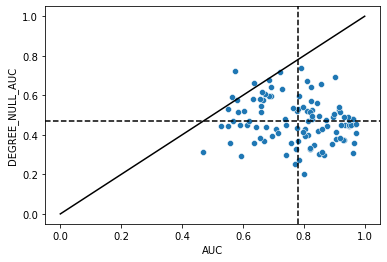

In [1116]:
df_exp, go_chrom  = run_egad(marker_gene_table.T, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1117]:
df_exp.sort_values(by=['AUC'])

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC  \
Testis                  0.583042       673.276452         0.477925   
Ovary                   0.589316       730.950257         0.542555   
Pancreas                0.603233       646.288669         0.439458   
Kidney                  0.614718       653.465099         0.447144   
Lung                    0.634565       692.570429         0.501236   
Eye                     0.661006       704.942335         0.525834   
Liver                   0.666120       725.593532         0.556382   
Brain                   0.667522       654.685447         0.460337   
Gastrointestinal tract  0.678213       659.742321         0.468117   
Embryo                  0.679932       743.855537         0.579671   
Heart                   0.688040       692.582355         0.507077   
Teeth                   0.693787       659.003802         0.449017   
Skin                    0.704226       645.574603         0.453530   
Muscle                  0.753181       735.452337         0.569359   
White adipose tissue    0.766958       718.140880         0.527484   
Immune system           0.819151       657.457364         0.447922   

                             P_Value  
Testis                  5.006410e-02  
Ovary                   3.495023e-02  
Pancreas                2.745406e-08  
Kidney                  5.687031e-08  
Lung                    6.685850e-12  
Eye                     4.544724e-11  
Liver                   7.543391e-24  
Brain                   1.519427e-11  
Gastrointestinal tract  4.973619e-27  
Embryo                  2.982426e-11  
Heart                   1.612842e-05  
Teeth                   5.407901e-07  
Skin                    8.943674e-15  
Muscle                  2.923846e-38  
White adipose tissue    9.676295e-24  
Immune system           1.144918e-47

(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


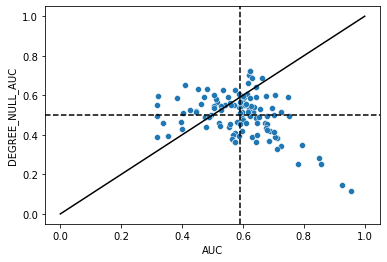

In [1194]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1188]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     55410.542654     55409.765056     55410.542654   
ENSG00000227232     55409.765056     55410.542654     55409.765092   
ENSG00000278267     55410.542654     55409.765092     55410.542654   
ENSG00000243485     33000.547085     53014.059257     33000.547085   
ENSG00000284332     29730.909756     30806.991076     29730.909756   
...                          ...              ...              ...   
ENSG00000100312     25559.415937     25188.882956     25559.415937   
ENSG00000254499     18976.471612     18908.408863     18976.471612   
ENSG00000213683      2874.608697      2893.388777      2874.608697   
ENSG00000184319     33809.399875     34690.246946     33809.399875   
ENSG00000079974     34732.843055     35761.283779     34732.843055   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     33000.547085     29730.909756     29730.909756   
ENSG00000227232     53014.059257     30806.991076     30806.991076   
ENSG00000278267     33000.547085     29730.909756     29730.909756   
ENSG00000243485     55409.971305     55409.740638     55409.740638   
ENSG00000284332     55409.740638     55410.542654     55410.542654   
...                          ...              ...              ...   
ENSG00000100312     21921.241550     20481.246188     20481.246188   
ENSG00000254499     17807.251800     16755.347431     16755.347431   
ENSG00000213683      3069.751737      3005.910316      3005.910316   
ENSG00000184319     21923.271002     18040.539036     18040.539036   
ENSG00000079974     23410.200529     19229.714903     19229.714903   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     36560.544197     35712.759461     34463.434237   
ENSG00000227232     37578.947492     36951.153083     35545.184413   
ENSG00000278267     36560.544197     35712.759461     34463.434237   
ENSG00000243485     29450.096939     27903.354884     26819.065664   
ENSG00000284332     25589.090442     23940.350228     23096.640748   
...                          ...              ...              ...   
ENSG00000100312     23050.988170     20730.184287     21284.288237   
ENSG00000254499     16073.187156     14716.574065     15205.092301   
ENSG00000213683      2800.575869      2686.427126      2695.345717   
ENSG00000184319     41136.809180     45904.931900     44044.685884   
ENSG00000079974     42085.540732     46002.948178     44273.762565   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     31977.483902  ...     37335.970556     33646.614725   
ENSG00000227232     33195.362969  ...     38629.878282     34795.043971   
ENSG00000278267     31977.483902  ...     37335.970556     33646.614725   
ENSG00000243485     23763.546832  ...     27320.402727     25485.716112   
ENSG00000284332     19819.880574  ...     22858.243029     21534.395310   
...                          ...  ...              ...              ...   
ENSG00000100312     18117.180876  ...     28759.341169     27263.337343   
ENSG00000254499     12942.101848  ...     19664.585073     19736.229548   
ENSG00000213683      2566.208000  ...      2648.033125      2787.245412   
ENSG00000184319     49638.153571  ...     52490.390058     46688.629433   
ENSG00000079974     48937.853197  ...     52731.871352     47618.333824   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     33474.450172     31754.130813     11958.799201   
ENSG00000227232     34630.521620     32246.606585     11481.742641   
ENSG00000278267     33474.450172     31754.130813     11958.799201   
ENSG00000243485     25534.955974     26713.543980     10954.359595   
ENSG00000284332     21487.890175     23674.316444     10990.026719   
...                          ...              ...              ...   
ENSG00000100312     48672.724649     29661.806311     55409.302693   
ENSG00000254499     18721.382857 

In [1195]:
df_2d_jac.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Immune system-Natural killer cells                0.684206     5.567047e+07   
Pancreas-Gamma (PP) cells                         0.687704     6.030270e+07   
Immune system-Classical Monocytes                 0.697055     6.721752e+07   
Kidney-Immune cells                               0.702944     5.436364e+07   
Gastrointestinal tract-Goblet cells               0.703677     6.033314e+07   
Eye-Starburst amacrine cells                      0.705281     5.927721e+07   
Immune system--T cells                            0.705926     6.818596e+07   
Eye-Glycinergic amacrine cells                    0.713060     5.625850e+07   
Eye-Tachykinin GABAergic amacrine cells           0.713126     5.867519e+07   
Eye-Cholinergic GABAergic amacrine cells          0.713126     5.867519e+07   
Eye-GABAergic amacrine cells                      0.725118     5.719714e+07   
Skin-Keratinocytes                                0.725577     6.409354e+07   
Immune system-Intermediate monocytes              0.749089     6.956012e+07   
Immune system-Non-classical monocytes             0.751511     6.229179e+07   
White adipose tissue-Smooth Muscle cells          0.780879     4.922377e+07   
White adipose tissue-Adipocytes                   0.794001     5.635899e+07   
White adipose tissue-Lymphatic Endothelial cells  0.848315     5.477354e+07   
White adipose tissue-Endothelial cells            0.857126     5.055738e+07   
White adipose tissue-Pericytes                    0.926933     4.663613e+07   
White adipose tissue-Endometrium                  0.955263     4.448853e+07   

                                                  DEGREE_NULL_AUC  \
Immune system-Natural killer cells                       0.367220   
Pancreas-Gamma (PP) cells                                0.419237   
Immune system-Classical Monocytes                        0.534587   
Kidney-Immune cells                                      0.416660   
Gastrointestinal tract-Goblet cells                      0.499639   
Eye-Starburst amacrine cells                             0.388386   
Immune system--T cells                                   0.603222   
Eye-Glycinergic amacrine cells                           0.326630   
Eye-Tachykinin GABAergic amacrine cells                  0.382071   
Eye-Cholinergic GABAergic amacrine cells                 0.382071   
Eye-GABAergic amacrine cells                             0.345058   
Skin-Keratinocytes                                       0.513763   
Immune system-Intermediate monocytes                     0.592135   
Immune system-Non-classical monocytes                    0.493370   
White adipose tissue-Smooth Muscle cells                 0.252456   
White adipose tissue-Adipocytes                          0.349302   
White adipose tissue-Lymphatic Endothelial cells         0.282376   
White adipose tissue-Endothelial cells                   0.254782   
White adipose tissue-Pericytes                           0.147855   
White adipose tissue-Endometrium                         0.118189   

                                                       P_Value  
Immune system-Natural killer cells                1.116089e-02  
Pancreas-Gamma (PP) cells                         5.340765e-04  
Immune system-Classical Monocytes                 9.580261e-03  
Kidney-Immune cells                               3.555981e-06  
Gastrointestinal tract-Goblet cells               8.271379e-05  
Eye-Starburst amacrine cells                      2.489675e-03  
Immune system--T cells                            4.045537e-03  
Eye-Glycinergic amacrine cells                    3.496909e-03  
Eye-Tachykinin GABAergic amacrine cells           5.076309e-03  
Eye-Cholinergic GABAergic amacrine cells          5.076309e-03  
Eye-GABAergic amacrine cells                      4.479939e-03  
Skin-Keratinocytes                                7.796867e-08  
Immune system-Intermediate monocytes              2.058223e-03  
Immune system-Non-classical monocyt

In [1108]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC  \
Pro-B cells                  0.658556     6.767224e+07         0.533084   
Pre-B cells                  0.629870     6.552121e+07         0.482953   
Naive B cells                0.645739     6.439075e+07         0.501591   
Memory B cells               0.655465     6.491568e+07         0.514402   
Plasma B cells               0.655465     6.491568e+07         0.514402   
...                               ...              ...              ...   
Adipocytes                   0.668608     6.023546e+07         0.437885   
Smooth Muscle cells          0.731094     5.349009e+07         0.324507   
Lymphatic Endothelial cells  0.820355     5.477354e+07         0.282376   
Endometrium                  0.950476     4.448853e+07         0.118189   
Odontoblasts                 0.395001     6.400586e+07         0.467220   

                                  P_Value  
Pro-B cells                  1.305770e-02  
Pre-B cells                  4.023952e-02  
Naive B cells                2.725271e-02  
Memory B cells               1.643722e-02  
Plasma B cells               1.643722e-02  
...                                   ...  
Adipocytes                   1.374553e-02  
Smooth Muscle cells          2.206827e-04  
Lymphatic Endothelial cells  1.709972e-06  
Endometrium                  3.748882e-08  
Odontoblasts                 1.041311e-01  

[111 rows x 4 columns]

In [1031]:
df_dist_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972         0.000000         0.000056         0.000180   
ENSG00000227232         0.000056         0.000000         0.000082   
ENSG00000278267         0.000180         0.000082         0.000000   
ENSG00000243485         0.000057         0.058824         0.000083   
ENSG00000284332         0.000054         0.001258         0.000077   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972         0.000057         0.000054         0.000041   
ENSG00000227232         0.058824         0.001258         0.000154   
ENSG00000278267         0.000083         0.000077         0.000054   
ENSG00000243485         0.000000         0.001232         0.000153   
ENSG00000284332         0.001232         0.000000         0.000175   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972         0.000025         0.000022         0.000019   
ENSG00000227232         0.000044         0.000036         0.000028   
ENSG00000278267         0.000029         0.000025         0.000021   
ENSG00000243485         0.000044         0.000036         0.000028   
ENSG00000284332         0.000045         0.000037         0.000029   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         0.000008  ...         0.000000         0.000000   
ENSG00000227232         0.000010  ...         0.000000         0.000000   
ENSG00000278267         0.000009  ...         0.000000         0.000000   
ENSG00000243485         0.000010  ...         0.000000         0.000000   
ENSG00000284332         0.000010  ...         0.000000         0.000000   
...                          ...  ...              ...              ...   
ENSG00000100312         0.000000  ...         0.000009         0.000015   
ENSG00000254499         0.000000  ...         0.000009         0.000014   
ENSG00000213683         0.000000  ...         0.000008         0.000012   
ENSG00000184319         0.000000  ...         0.000008         0.000011   
ENSG00000079974         0.000000  ...         0.000006         0.000009   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972         0.000000         0.000000         0.000000   
ENSG00000227232         0.000000         0.000000         0.000000   
ENSG00000278267         0.000000         0.000000         0.000000   
ENSG00000243485         0.000000         0.000000         0.000000   
ENSG00000284332         0.000000         0.000000         0.000000   
...                          ...              ...              ...   
ENSG00000100312         0.000016         0.000021         0.017857   
ENSG00000254499         0.000014 

In [1037]:
df_dist_corr_inv = 1/df_dist_corr

In [1038]:
df_dist_corr_inv.replace([np.inf, -np.inf], 0, inplace=True)

In [1196]:
df_dist_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972              0.0          17702.0           5568.0   
ENSG00000227232          17702.0              0.0          12134.0   
ENSG00000278267           5568.0          12134.0              0.0   
ENSG00000243485          17685.0             17.0          12117.0   
ENSG00000284332          18497.0            795.0          12929.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972          17685.0          18497.0          24213.0   
ENSG00000227232             17.0            795.0           6511.0   
ENSG00000278267          12117.0          12929.0          18645.0   
ENSG00000243485              0.0            812.0           6528.0   
ENSG00000284332            812.0              0.0           5716.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972          40604.0          45729.0          53550.0   
ENSG00000227232          22902.0          28027.0          35848.0   
ENSG00000278267          35036.0          40161.0          47982.0   
ENSG00000243485          22919.0          28044.0          35865.0   
ENSG00000284332          22107.0          27232.0          35053.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         121855.0  ...              0.0              0.0   
ENSG00000227232         104153.0  ...              0.0              0.0   
ENSG00000278267         116287.0  ...              0.0              0.0   
ENSG00000243485         104170.0  ...              0.0              0.0   
ENSG00000284332         103358.0  ...              0.0              0.0   
...                          ...  ...              ...              ...   
ENSG00000100312              0.0  ...         110022.0          68392.0   
ENSG00000254499              0.0  ...         115347.0          73717.0   
ENSG00000213683              0.0  ...         127261.0          85631.0   
ENSG00000184319              0.0  ...         128774.0          87144.0   
ENSG00000079974              0.0  ...         155490.0         113860.0   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972              0.0              0.0              0.0   
ENSG00000227232              0.0              0.0              0.0   
ENSG00000278267              0.0              0.0              0.0   
ENSG00000243485              0.0              0.0              0.0   
ENSG00000284332              0.0              0.0              0.0   
...                          ...              ...              ...   
ENSG00000100312          63781.0          46832.0             56.0   
ENSG00000254499          69106.0 

In [1197]:
df_dist_corr_inv

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972         0.000000         0.000056         0.000180   
ENSG00000227232         0.000056         0.000000         0.000082   
ENSG00000278267         0.000180         0.000082         0.000000   
ENSG00000243485         0.000057         0.058824         0.000083   
ENSG00000284332         0.000054         0.001258         0.000077   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972         0.000057         0.000054         0.000041   
ENSG00000227232         0.058824         0.001258         0.000154   
ENSG00000278267         0.000083         0.000077         0.000054   
ENSG00000243485         0.000000         0.001232         0.000153   
ENSG00000284332         0.001232         0.000000         0.000175   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972         0.000025         0.000022         0.000019   
ENSG00000227232         0.000044         0.000036         0.000028   
ENSG00000278267         0.000029         0.000025         0.000021   
ENSG00000243485         0.000044         0.000036         0.000028   
ENSG00000284332         0.000045         0.000037         0.000029   
...                          ...              ...              ...   
ENSG00000100312         0.000000         0.000000         0.000000   
ENSG00000254499         0.000000         0.000000         0.000000   
ENSG00000213683         0.000000         0.000000         0.000000   
ENSG00000184319         0.000000         0.000000         0.000000   
ENSG00000079974         0.000000         0.000000         0.000000   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         0.000008  ...         0.000000         0.000000   
ENSG00000227232         0.000010  ...         0.000000         0.000000   
ENSG00000278267         0.000009  ...         0.000000         0.000000   
ENSG00000243485         0.000010  ...         0.000000         0.000000   
ENSG00000284332         0.000010  ...         0.000000         0.000000   
...                          ...  ...              ...              ...   
ENSG00000100312         0.000000  ...         0.000009         0.000015   
ENSG00000254499         0.000000  ...         0.000009         0.000014   
ENSG00000213683         0.000000  ...         0.000008         0.000012   
ENSG00000184319         0.000000  ...         0.000008         0.000011   
ENSG00000079974         0.000000  ...         0.000006         0.000009   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972         0.000000         0.000000         0.000000   
ENSG00000227232         0.000000         0.000000         0.000000   
ENSG00000278267         0.000000         0.000000         0.000000   
ENSG00000243485         0.000000         0.000000         0.000000   
ENSG00000284332         0.000000         0.000000         0.000000   
...                          ...              ...              ...   
ENSG00000100312         0.000016         0.000021         0.017857   
ENSG00000254499         0.000014 

(1939, 1939)
(1939, 229)
0.9921356842202459
0.9440389326761215


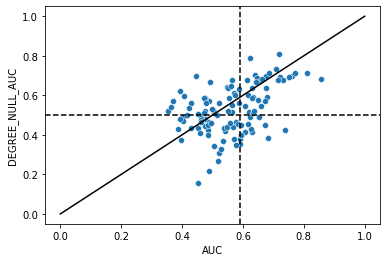

In [1198]:
df_dist, go_chrom  = run_egad(marker_gene_table.T, df_dist_corr_inv)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_dist, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1204]:
df_dist.sort_values(by=['AUC']).tail(50)

AUC  AVG_NODE_DEGREE  \
Gastrointestinal tract-Crypt cells         0.584975         1.000053   
Liver-Kupffer cells                        0.585710         1.000053   
Liver-Hepatocytes                          0.588006         1.000072   
Eye-Glycinergic amacrine cells             0.589353         1.000021   
Pancreas-Epsilon cells                     0.591594         1.000016   
Eye-Tachykinin GABAergic amacrine cells    0.592545         1.000022   
Eye-Cholinergic GABAergic amacrine cells   0.592545         1.000022   
Lung-Cancer stem cells                     0.594761         1.000020   
Pancreas-Alpha cells                       0.606081         1.000023   
Brain-Endothelial cells                    0.606838         1.000020   
Immune system-CD8+ NKT-like cells          0.613430         1.000133   
Embryo-Epiblast cells                      0.615422         1.000059   
Liver-Cholangiocytes                       0.616608         1.000094   
Eye-Retinal pigment epithelial cells       0.620644         1.000054   
Immune system-Intermediate monocytes       0.623721         1.000202   
Eye-Endothelial cells                      0.624188         1.000021   
Brain-Astrocytes                           0.627134         1.000014   
Kidney-Mesangial cells                     0.629621         1.000020   
Immune system-Granulocytes                 0.630352         1.000044   
Brain-Microglial cells                     0.630374         1.000057   
Kidney-Distal tubule cells                 0.633334         1.000065   
Eye-Microglial cells                       0.634112         1.000056   
Lung-Endothelial cell                      0.637206         1.000028   
Immune system-Classical Monocytes          0.640223         1.000163   
Lung-Immune system cells                   0.644361         1.000472   
Immune system-Myeloid Dendritic cells      0.645060         1.000064   
Lung-Mesothelial cells                     0.649280         1.000032   
Lung-Ciliated cells                        0.651214         1.000023   
Pancreas-Immune system cells               0.655785         1.000849   
Lung-Pulmonary alveolar type II cells      0.659779         1.000052   
Skin-Keratinocytes                         0.662530         1.000055   
White adipose tissue-Immune cells          0.672057         1.000063   
White adipose tissue-Adipocytes            0.672646         1.000014   
Immune system-Naive CD4+ T cells           0.676082         1.000132   
Immune system-Basophils                    0.676249         1.000071   
Lung-Pulmonary alveolar type I cells       0.678018         1.000622   
Eye-GABAergic amacrine cells               0.680800         1.000022   
Kidney-Immune cells                        0.684167         1.000084   
Immune system-ISG expressing immune cells  0.707231         1.000064   
Immune system-CD4+ NKT-like cells          0.713557         1.000133   
Immune system-Non-classical monocytes      0.719281         1.001471   
Immune system-Effector CD8+ T cells        0.721804         1.000123   
Immune system--T cells                     0.730123         1.000120   
Eye-Starburst amacrine cells               0.736883         1.000079   
Immune system-Neutrophils                  0.749694         1.000063   
Immune system-Effector CD4+ T cells        0.749782         1.000139   
Immune system-Naive CD8+ T cells           0.761628         1.000118   
Immune system-Memory CD8+ T cells          0.770965         1.000120   
Immune system-Memory CD4+ T cells          0.808968         1.000134   
Skin-Langerhans cells                      0.856084         1.000057   

                                           DEGREE_NULL_AUC       P_Value  
Gastrointestinal tract-Crypt cells                0.454920  3.897509e-02  
Liver-Kupffer cells                               0.631423  3.395478e-02  
Liver-Hepatocytes                                 0.559025  3.138970e-04  
Eye-Glycinergic amacrine cells                    0.353572  1.782636e-01  


In [1079]:
df_2d_jac.reset_index(inplace=True)

In [1080]:
df_dist.reset_index(inplace=True)

In [1081]:
df_exp.reset_index(inplace=True)

In [1082]:
coexp_contact = df_2d_jac.merge(df_exp, left_on='index', right_on='index')

In [1083]:
coexp_contact = coexp_contact.merge(df_dist, left_on='index', right_on='index')

In [1181]:
coexp_contact = coexp_contact.merge(marker_gene_table.T.sum().reset_index())



index   0
0       Immune system-Pro-B cells  20
1       Immune system-Pre-B cells  18
2     Immune system-Naive B cells  22
3    Immune system-Memory B cells  23
4    Immune system-Plasma B cells  23
..                            ...  ..
224            Teeth-Odontoblasts  12
225       Teeth-Endothelial cells   9
226            Teeth-Immune cells  12
227             Teeth-Glial cells   9
228        Teeth-Epithelial cells  11

[229 rows x 2 columns]

In [1183]:
coexp_contact[['index', 'AUC_x', 'AUC_y', 'AUC', 0]].sort_values(by=['AUC_x']).tail(10)

index     AUC_x     AUC_y  \
49            Eye-Tachykinin GABAergic amacrine cells  0.713126  0.818700   
41                       Eye-GABAergic amacrine cells  0.725118  0.834922   
93                                 Skin-Keratinocytes  0.725577  0.891835   
17              Immune system-Non-classical monocytes  0.751511  0.915098   
100          White adipose tissue-Smooth Muscle cells  0.780879  0.843624   
99                    White adipose tissue-Adipocytes  0.794001  0.916220   
103  White adipose tissue-Lymphatic Endothelial cells  0.848315  0.798361   
102            White adipose tissue-Endothelial cells  0.857126  0.855704   
101                    White adipose tissue-Pericytes  0.926933  0.820451   
104                  White adipose tissue-Endometrium  0.955263  0.851056   

          AUC   0  
49   0.592545  34  
41   0.680800  28  
93   0.662530  46  
17   0.719281  25  
100  0.430455  22  
99   0.672646  16  
103  0.519182  24  
102  0.578194  20  
101  0.488972  20  
104  0.452452  13

In [1161]:
coexp_contact[['index', 'AUC_x', 'AUC_y', 'AUC']].sort_values(by=['AUC_x']).head(20)['index'].tolist()

['Eye-Rod photoreceptor cells',
 'Muscle-Myoblasts',
 'Lung-Endothelial cell',
 'Lung-Ciliated cells',
 'Brain-Neural Progenitor cells',
 'Eye-Retinal pigment epithelial cells',
 'Eye-Cone photoreceptor cells',
 'Muscle-Satellite cells',
 'Pancreas-Pancreatic stellate cells',
 'Lung-Basal cells (Airway progenitor cells)',
 'Brain-Astrocytes',
 'Brain-Endothelial cells',
 'Kidney-Proximal tubule cells',
 'Kidney-Distal tubule cells',
 'Skin-Melanocytes',
 'Lung-Mesothelial cells',
 'Eye-Cone bipolar cells',
 'Gastrointestinal tract-Parietal cells',
 'Lung-Cancer stem cells',
 'Skin-Merkel cells']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_y', ylabel='AUC_x'>

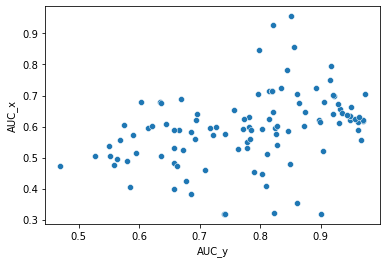

In [1063]:
sns.scatterplot(coexp_contact['AUC_y'], coexp_contact['AUC_x'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='AUC_y'>

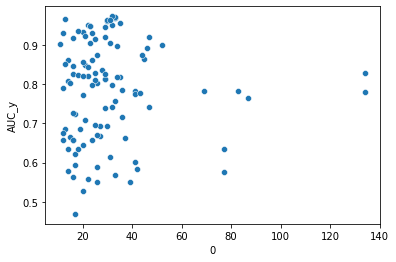

In [1187]:
sns.scatterplot(coexp_contact[0], coexp_contact['AUC_y'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC', ylabel='AUC_y'>

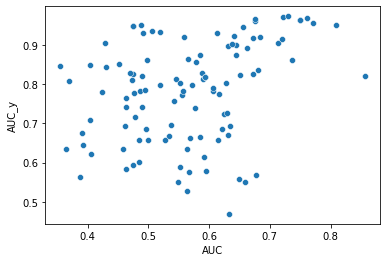

In [1095]:
sns.scatterplot(coexp_contact['AUC'], coexp_contact['AUC_y'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC', ylabel='AUC_x'>

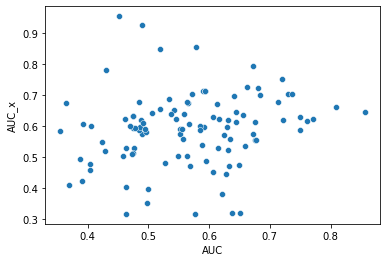

In [1094]:
sns.scatterplot(coexp_contact['AUC'], coexp_contact['AUC_x'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC'>

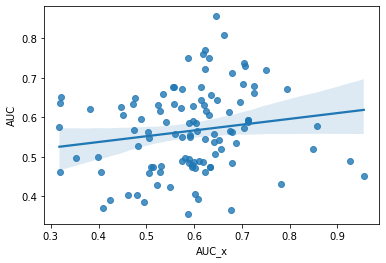

In [1089]:
sns.regplot(coexp_contact['AUC_x'], coexp_contact['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC_y'>

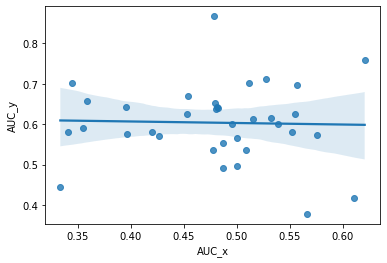

In [1042]:
sns.regplot(coexp_contact['AUC_x'], coexp_contact['AUC_y'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC_y'>

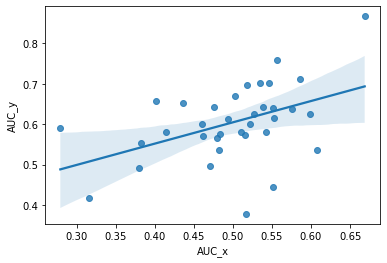

In [1018]:
sns.regplot(coexp_contact['AUC_x'], coexp_contact['AUC_y'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC_y'>

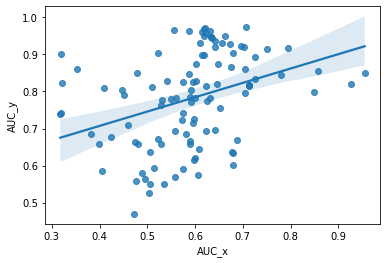

In [986]:
sns.regplot(coexp_contact['AUC_x'], coexp_contact['AUC_y'])

In [1193]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)

df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


<ipython-input-1193-9f278349537e>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [1189]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
#df  = df[df['Tissue'] == 'Brain']
df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
#df['combined_type'] = df['Tissue'] 

#df = df[df['combined_type'].isin(['Brain-Astrocytes',
# 'Brain-Endothelial cells',
# 'Kidney-Proximal tubule cells',
# 'Kidney-Distal tubule cells',])]
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)

<ipython-input-1189-f067ec03ad4e>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [1190]:
marker_gene_table

ENSG00000170442  ENSG00000180176  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000165810  ENSG00000143546  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000187017  ENSG00000139193  \
Immune system-Pro-B cells                   0                1   
Immune system-Pre-B cells                   0                1   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                1   
Immune system-Plasma B cells                0                1   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000107984  ENSG00000187094  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000198053  del  ...  ENSG00000008256  \
Immune system-Pro-B cells                   0    0  ...                0   
Immune system-Pre-B cells                   0    0  ...                0   
Immune system-Naive B cells                 0    0  ...                0   
Immune system-Memory B cells                0    0  ...                0   
Immune system-Plasma B cells                0    0  ...                0   
...                                       ...  ...  ...              ...   
Teeth-Odontoblasts                          0    0  ...                0   
Teeth-Endothelial cells                     0    0  ...                0   
Teeth-Immune cells                          0    0  ...                0   
Teeth-Glial cells                           0    0  ...                0   
Teeth-Epithelial cells

In [1177]:
marker_gene_table.T.sum()

Immune system-Pro-B cells       20
Immune system-Pre-B cells       18
Immune system-Naive B cells     22
Immune system-Memory B cells    23
Immune system-Plasma B cells    23
                                ..
Teeth-Odontoblasts              12
Teeth-Endothelial cells          9
Teeth-Immune cells              12
Teeth-Glial cells                9
Teeth-Epithelial cells          11
Length: 229, dtype: int64

In [987]:
df_TF = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/main_download.csv', sep='\t')

In [922]:
df_TF.columns

Index(['PMID', 'Gene Name', 'Gene Type', 'Cell Name', 'Cell Type',
       'Tissue Type', 'Experiment Type', 'Experimental Method', 'Title',
       'Description of Gene', 'Interacting Gene', 'CellOntologyID'],
      dtype='object')

In [988]:
df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['Gene Name'] ]



df_TF = df_TF[df_TF['ensg_gene'] != 'del']

df_TF = df_TF[df_TF['Gene Type'] == 'I Marker']

df_TF = df_TF[df_TF['Cell Type'] == 'Normal cell']

df_TF['counter'] = 1
df_TF_egad = df_TF.pivot_table(index=["ensg_gene"], columns='Cell Name', values='counter',  aggfunc='max')

In [773]:

top_cell_names = df_TF.groupby(['Cell Name'])['counter'].sum().sort_values().head(-1).tail(3).index.tolist()

In [774]:
df_TF = df_TF[df_TF['Cell Name'].isin(top_cell_names)]

In [816]:
df_TF = df_TF.drop_duplicates(subset=['ensg_gene'], keep = False)

In [756]:
df_TF = df_TF.drop_duplicates(subset=['ensg_gene'])

In [736]:
df_TF = df_TF.set_index('ensg_gene')

In [759]:
pd.melt(df_TF, id_vars=['Cell Name','ensg_gene'], value_vars=['va'])

Cell Name        ensg_gene variable  value
0             T cell  ENSG00000150782  counter      1
1             T cell  ENSG00000115602  counter      1
2    Epithelial cell  ENSG00000067082  counter      1
3    Epithelial cell  ENSG00000125482  counter      1
4    Epithelial cell  ENSG00000113722  counter      1
..               ...              ...      ...    ...
102           T cell  ENSG00000188389  counter      1
103   Adipocyte cell  ENSG00000124459  counter      1
104           T cell  ENSG00000172175  counter      1
105           T cell  ENSG00000138795  counter      1
106           T cell  ENSG00000118263  counter      1

[107 rows x 4 columns]

In [997]:
df_TF_egad = df_TF.pivot_table(index=["ensg_gene"], columns='Cell Name', values='counter',  aggfunc='max')

In [998]:
df_TF_egad = df_TF_egad.fillna(0)

In [999]:
df_TF_egad.max().max()

1.0

In [1000]:
df_TF_egad

Cell Name        Adipocyte cell  Adipose cell  Adrenal cell  Airway cell  \
ensg_gene                                                                  
ENSG00000000971             0.0           0.0           0.0          0.0   
ENSG00000001084             0.0           0.0           0.0          0.0   
ENSG00000001626             0.0           0.0           0.0          0.0   
ENSG00000001631             0.0           0.0           0.0          0.0   
ENSG00000002746             0.0           0.0           0.0          0.0   
...                         ...           ...           ...          ...   
ENSG00000281880             0.0           0.0           0.0          0.0   
ENSG00000283203             0.0           0.0           0.0          0.0   
ENSG00000284010             0.0           0.0           0.0          0.0   
ENSG00000284204             0.0           0.0           0.0          0.0   
ENSG00000284567             0.0           0.0           0.0          0.0   

Cell Name        Artery cell  Astrocyte cell  B cell  Basal cell  \
ensg_gene                                                          
ENSG00000000971          0.0             0.0     0.0         0.0   
ENSG00000001084          0.0             0.0     0.0         0.0   
ENSG00000001626          0.0             0.0     0.0         0.0   
ENSG00000001631          0.0             0.0     0.0         0.0   
ENSG00000002746          0.0             0.0     0.0         0.0   
...                      ...             ...     ...         ...   
ENSG00000281880          0.0             0.0     0.0         0.0   
ENSG00000283203          0.0             0.0     0.0         0.0   
ENSG00000284010          0.0             0.0     0.0         0.0   
ENSG00000284204          0.0             0.0     0.0         0.0   
ENSG00000284567          0.0             0.0     0.0         0.0   

Cell Name        Bile duct cell  Blood cell  ...  T cell  T stem cell  \
ensg_gene                                    ...                        
ENSG00000000971             0.0         0.0  ...     0.0          0.0   
ENSG00000001084             0.0         0.0  ...     0.0          0.0   
ENSG00000001626             0.0         0.0  ...     0.0          0.0   
ENSG00000001631             0.0         0.0  ...     0.0          0.0   
ENSG00000002746             0.0         0.0  ...     0.0          0.0   
...                         ...         ...  ...     ...          ...   
ENSG00000281880             0.0         0.0  ...     0.0          0.0   
ENSG00000283203             0.0         0.0  ...     0.0          0.0   
ENSG00000284010             0.0         0.0  ...     0.0          0.0   
ENSG00000284204             0.0         0.0  ...     0.0          0.0   
ENSG00000284567             0.0         0.0  ...     0.0          0.0   

Cell Name        Theca interna cell  Thrombus cell  Thymocyte cell  \
ensg_gene                                                            
ENSG00000000971                 0.0            0.0             0.0   
ENSG00000001084                 0.0            0.0             0.0   
ENSG00000001626                 0.0            0.0             0.0   
ENSG00000001631                 0.0            0.0             0.0   
ENSG00000002746                 0.0            0.0             0.0   
...                             ...            ...             ...   
ENSG00000281880                 0.0            0.0             0.0   
ENSG00000283203                 0.0            0.0             0.0   
ENSG00000284010                 0.0            0.0             0.0   
ENSG00000284204                 0.0            0.0             0.0   
ENSG00000284567                 0.0            0.0             0.0   

Cell Name        Trophoblast cell  Trophoblastic cell  Tubular cell  \
ensg_gene                                                             
ENSG00000000971               0.0                 0.0           0.0   
ENSG00000001084               0.0                 0.

In [668]:
df_TF.groupby(['Tissue Type'])['counter'].sum().sort_values().tail(5)

Tissue Type
Adipose        42
Bone marrow    46
Embryo         48
Liver          51
Bone           58
Name: counter, dtype: int64

In [ ]:
df_TF.groupby(['Tissue Type'])['counter'].sum()

In [1174]:
marker_gene_table.T.sum()

Kidney-Proximal tubule cells    21
Kidney-Distal tubule cells      17
Brain-Astrocytes                15
Brain-Endothelial cells         12
dtype: int64

In [355]:
marker_gene_table.index

Index(['Immune system', 'Pancreas', 'Liver', 'Eye', 'Kidney', 'Brain', 'Lung',
       'Embryo', 'Gastrointestinal tract', 'Muscle', 'Skin', 'Heart', 'Ovary',
       'Testis', 'White adipose tissue', 'Teeth'],
      dtype='object')

In [374]:
marker_gene_table.sum().max()

10

In [373]:
marker_gene_table.median()

ENSG00000170442    0.0
ENSG00000180176    0.0
ENSG00000165810    0.0
ENSG00000143546    0.0
ENSG00000187017    0.0
                  ... 
ENSG00000016082    0.0
ENSG00000127412    0.0
del                0.0
ENSG00000054179    0.0
del                0.0
Length: 2200, dtype: float64

In [105]:
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


<ipython-input-105-cf2460fa5d81>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [112]:
brain_genes = df[df['Tissue'] == 'Brain']['Marker genes'].str.cat(sep=',').split(",")

In [113]:
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in brain_genes  ]

In [104]:
marker_gene_table.index

Index(['Immune system-Pro-B cells', 'Immune system-Pre-B cells',
       'Immune system-Naive B cells', 'Immune system-Memory B cells',
       'Immune system-Plasma B cells', 'Immune system-Naive CD8+ T cells',
       'Immune system-Naive CD4+ T cells', 'Immune system-Memory CD8+ T cells',
       'Immune system-Memory CD4+ T cells',
       'Immune system-Effector CD8+ T cells',
       ...
       'White adipose tissue-Endometrium', 'White adipose tissue-Immune cells',
       'White adipose tissue-Epithelial cells', 'Teeth-Mesenchymal stem cells',
       'Teeth-Fibroblasts', 'Teeth-Odontoblasts', 'Teeth-Endothelial cells',
       'Teeth-Immune cells', 'Teeth-Glial cells', 'Teeth-Epithelial cells'],
      dtype='object', length=229)

In [85]:
marker_gene_table.T.toarray()

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [121]:
len(list(set(all_gene_list)))

155

In [931]:
df_2d_jac, hh = run_egad(df_TF_egad, df_jac_corr)

(1543, 1543)
(1543, 2)
0.36098509397278034
0.0


In [932]:
marker_gene_table.T.columns

Index(['Immune system', 'Pancreas', 'Liver'], dtype='object')

In [933]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
Cell Type                                                        
Cancer cell  0.527444     5.490973e+07         0.540598  0.008692
Normal cell  0.521999     5.377752e+07         0.463484  0.029715

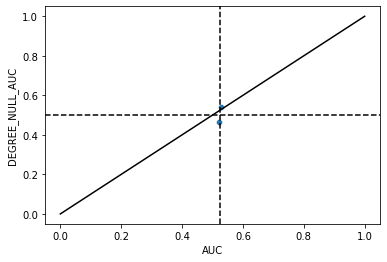

In [934]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1163]:
y = marker_gene_table.T

genes_intersect = y.index.intersection(df_jac_corr.index)

nw = df_jac_corr.loc[genes_intersect, genes_intersect]

marker_gene_table = marker_gene_table.loc[:, genes_intersect]

In [741]:
df_TF = df_TF.loc[genes_intersect, :]

In [463]:
df_TF

PMID Gene Name Gene Type        Cell Name    Cell Type  \
ENSG00000198353   7915745     HOXC4  TFMarker  epithelial cell  Cancer cell   
ENSG00000186395   7915745     KRT10  TFMarker  epithelial cell  Cancer cell   
ENSG00000172020   8477653     GAP43  TFMarker       Nerve cell  Cancer cell   
ENSG00000017427   8477653      IGF1  TFMarker       Nerve cell  Cancer cell   
ENSG00000166407   9020185      LMO1  TFMarker           T cell  Cancer cell   
...                   ...       ...       ...              ...          ...   
ENSG00000172175  32388054     MALT1  TFMarker           T cell  Normal cell   
ENSG00000147862  32393888      NFIB  TFMarker        Stem cell  Normal cell   
ENSG00000008441  32393888      NFIX  TFMarker        Stem cell  Normal cell   
ENSG00000197024  32398665    ZNF398  TFMarker        Stem cell  Normal cell   
ENSG00000128602  32413283       SMO  TFMarker  Fibroblast cell  Normal cell   

                Tissue Type                   Experiment Type  \
ENSG00000198353        Skin  low-throughput + high-throughput   
ENSG00000186395        Skin  low-throughput + high-throughput   
ENSG00000172020       Brain                    low-throughput   
ENSG00000017427       Brain                    low-throughput   
ENSG00000166407       Lymph                    low-throughput   
...                     ...                               ...   
ENSG00000172175       Lymph                    low-throughput   
ENSG00000147862      Embryo  low-throughput + high-throughput   
ENSG00000008441      Embryo  low-throughput + high-throughput   
ENSG00000197024  Epithelium  low-throughput + high-throughput   
ENSG00000128602        Skin  low-throughput + high-throughput   

                                               Experimental Method  \
ENSG00000198353             RT-PCR;DNA-seq;Microscopic observation   
ENSG00000186395             RT-PCR;DNA-seq;Microscopic observation   
ENSG00000172020                                       Western blot   
ENSG00000017427                                       Western blot   
ENSG00000166407                  Weston blot;RT-PCR;Flow cytometry   
...                                                            ...   
ENSG00000172175                                       Western Blot   
ENSG00000147862  ATAC-Seq;ChIP-seq;Immunofluorescent staining;q...   
ENSG00000008441  ATAC-Seq;ChIP-seq;Immunofluorescent staining;q...   
ENSG00000197024  Immunofluorescent staining;Western blot;qPCR;R...   
ENSG00000128602  Western Blot;qRT-PCR;DNA-seq;Immunofluorescent...   

                                                             Title  \
ENSG00000198353  Expression of the homeobox gene HOXC4 in kerat...   
ENSG00000186395  Expression of the homeobox gene HOXC4 in kerat...   
ENSG00000172020  Insulin-Like Growth Factor I Regulates c-wtyc ...   
ENSG00000017427  Insulin-Like Growth Factor I Regulates c-wtyc ...   
ENSG00000166407  Transcriptional Activity of TAL1 in T Cell Acu...   
...                                                            ...   
ENSG00000172175  TAK1 lessens the activity of the paracaspase M...   
ENSG00000147862  NFI transcription factors provide chromatin  a...   
ENSG00000008441  NFI transcription factors provide chromatin  a...   
ENSG00000197024  The transcriptional regulator ZNF398 mediates ...   
ENSG00000128602  Bi-allelic Variations of SMO in Humans Cause a...   

                                               Description of Gene  \
ENSG00000198353  HOXC4 is expressed mainly in differentiated ke...   
ENSG00000186395  Further study of epidermal neoplasms with RISH...   
ENSG00000172020  Insulin-Like growth factor I regulates c-wtyc ...   
ENSG00000017427  IGF-I is a neurotrophic factor which exhibits ...   
ENSG00000166407  Ectopic TAL1 and RBTN1 or -2, together with so...   
...                                                            ...   
ENSG00000172175  The MALT1 paracaspase serves dual roles: it is...   
ENSG00000147862  NFIB and NFIX as crucial rheosta

In [90]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [703]:
species = df_TF.pop("Tissue Type")

In [742]:
species = df_TF.pop("Cell Name")

In [1167]:
species= marker_gene_table.T.idxmax(axis=1)


In [591]:
len(species.unique())

10

In [748]:
df_TF

PMID Gene Name Gene Type    Cell Type Tissue Type  \
ENSG00000150782  11466339      IL18  TFMarker  Normal cell       Lymph   
ENSG00000115602  11466339    IL1RL1  TFMarker  Normal cell       Lymph   
ENSG00000067082  12407152      KLF6  TFMarker  Normal cell         Eye   
ENSG00000125482  14576939      TTF1  TFMarker  Normal cell   Intestine   
ENSG00000113722  14655050      CDX1  TFMarker  Normal cell      Kidney   
...                   ...       ...       ...          ...         ...   
ENSG00000188389  32350076     PDCD1  TFMarker  Normal cell       Lymph   
ENSG00000124459  32363570     ZNF45  TFMarker  Normal cell     Adipose   
ENSG00000172175  32388054     MALT1  TFMarker  Normal cell       Lymph   
ENSG00000138795  32413598      LEF1  TFMarker  Normal cell       Lymph   
ENSG00000118263  32413598      KLF7  TFMarker  Normal cell       Lymph   

                                  Experiment Type  \
ENSG00000150782                    low-throughput   
ENSG00000115602                    low-throughput   
ENSG00000067082  low-throughput + high-throughput   
ENSG00000125482                    low-throughput   
ENSG00000113722  low-throughput + high-throughput   
...                                           ...   
ENSG00000188389                    low-throughput   
ENSG00000124459                   high-throughput   
ENSG00000172175                    low-throughput   
ENSG00000138795  low-throughput + high-throughput   
ENSG00000118263  low-throughput + high-throughput   

                                               Experimental Method  \
ENSG00000150782                   Flow-throughput cytometry;RT-PCR   
ENSG00000115602                   Flow-throughput cytometry;RT-PCR   
ENSG00000067082  Western blot;RT-PCR;DNA-seq;Immunofluorescent ...   
ENSG00000125482                            Microscopic observation   
ENSG00000113722  Microscopic observation;Immunohistochemistry;D...   
...                                                            ...   
ENSG00000188389                          Flow-throughput cytometry   
ENSG00000124459                         ATAC-seq;ChIP-seq;NTSYS-pc   
ENSG00000172175                                       Western Blot   
ENSG00000138795  qPCR;Flow-throughput cytometry;RNA-seq;Immunof...   
ENSG00000118263  qPCR;Flow-throughput cytometry;RNA-seq;Immunof...   

                                                             Title  \
ENSG00000150782  Human IL-18 receptor and ST2L are stable and s...   
ENSG00000115602  Human IL-18 receptor and ST2L are stable and s...   
ENSG00000067082  Regulation of corneal keratin-12 gene expressi...   
ENSG00000125482  CDX2 immunoreactivity in primary and metastati...   
ENSG00000113722  Down-regulation of a Gastric Transcription Fac...   
...                                                            ...   
ENSG00000188389  Delayed expression of PD1 and TIGIT on HIV- 1 ...   
ENSG00000124459  Multifaceted genome‑wide study identifes novel...   
ENSG00000172175  TAK1 lessens the activity of the paracaspase M...   
ENSG00000138795  Overexpression of early T cell differentiation...   
ENSG00000118263  Overexpression of early T cell differentiation...   

                                               Description of Gene  \
ENSG00000150782  ST2L and IL-18R are stable selective cell surf...   
ENSG00000115602  ST2L and IL-18R are stable selective cell surf...   
ENSG00000067082  The expression of KLF6 in HCE cells and its ro...   
ENSG00000125482  Although homeobox gene products, namely CDX2 a...   
ENSG00000113722  Down-regulation of Sox2, besides ectopic expre...   
...                                                            ...   
ENSG00000188389  Programmed cell death protein 1 (PD-1) is a tr...   
ENSG00000124459  BAI3, SLC22A11 and ZNF45 variants were located...   
ENSG00000172175  The MALT1 paracaspase serves dual roles: it is...   
ENSG00000138795  LEF1, KLF7, ID3, Eomes, BCL6, TCF7, FOXP1 and ...   
ENSG00000118263  LEF1, KLF7, ID3, Eomes, BC

In [232]:
iris = sns.load_dataset("iris")
species = iris.pop("species")

In [465]:
len(species.unique())

60

In [1168]:
species.unique()

array(['Brain-Astrocytes', 'Brain-Endothelial cells',
       'Kidney-Proximal tubule cells', 'Kidney-Distal tubule cells'],
      dtype=object)

In [1130]:
lut

{'Skin-Keratinocytes': (0.86, 0.3712, 0.33999999999999997),
 'White adipose tissue-Endometrium': (0.86, 0.6832, 0.33999999999999997),
 'White adipose tissue-Endothelial cells': (0.7247999999999999,
  0.86,
  0.33999999999999997),
 'Immune system-Non-classical monocytes': (0.41279999999999994,
  0.86,
  0.33999999999999997),
 'White adipose tissue-Lymphatic Endothelial cells': (0.33999999999999997,
  0.86,
  0.5792000000000002),
 'White adipose tissue-Pericytes': (0.33999999999999997,
  0.8287999999999999,
  0.86),
 'White adipose tissue-Smooth Muscle cells': (0.33999999999999997,
  0.5167999999999995,
  0.86),
 'Eye-GABAergic amacrine cells': (0.4752000000000003,
  0.33999999999999997,
  0.86),
 'White adipose tissue-Adipocytes': (0.7871999999999999,
  0.33999999999999997,
  0.86),
 'Eye-Tachykinin GABAergic amacrine cells': (0.86,
  0.33999999999999997,
  0.6207999999999999)}

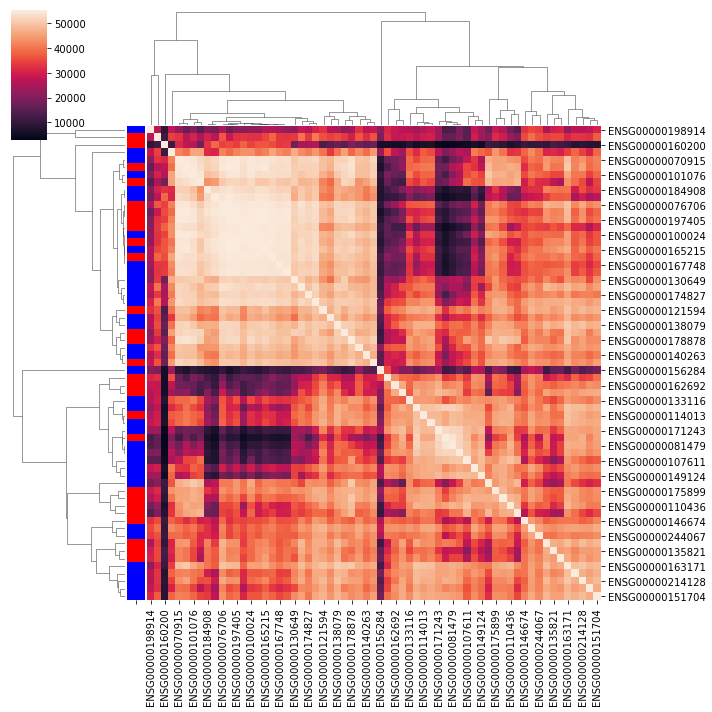

In [1170]:
#lut = dict(zip(species.unique(), sns.color_palette("hls", 10)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
lut = dict(zip(species.unique(), "rrbb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)
g = sns.clustermap(nw, row_colors=row_colors, row_cluster=True, metric="correlation")



In [1133]:
df_dist = nw.max().max()-nw
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-1133-e3971396f9ad>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


In [333]:
nw

ENSG00000099250  ENSG00000180176  ENSG00000165810  \
ENSG00000099250    207751.828125        10.638588         9.323639   
ENSG00000180176        10.638588         0.000000        25.645023   
ENSG00000165810         9.323639        25.645023         0.000000   
ENSG00000143546        11.132152        13.917123        18.505703   
ENSG00000127616        14.006284        22.074236        12.283423   
...                          ...              ...              ...   
ENSG00000146674        13.362648        14.150455        11.289581   
ENSG00000070748       359.954987         9.120216         8.084814   
ENSG00000125398        12.532973         8.040809        11.389224   
ENSG00000204482         0.000000         0.000000         0.000000   
ENSG00000148798       135.767487        14.163429        14.129701   

                 ENSG00000143546  ENSG00000127616  ENSG00000139193  \
ENSG00000099250        11.132152        14.006284        12.151247   
ENSG00000180176        13.917123        22.074236        20.265329   
ENSG00000165810        18.505703        12.283423        13.473481   
ENSG00000143546         0.000000        16.712633        14.499735   
ENSG00000127616        16.712633    319659.125000        30.450991   
...                          ...              ...              ...   
ENSG00000146674        16.308601        10.527434        12.449506   
ENSG00000070748        12.561810         8.281740         9.839720   
ENSG00000125398        12.181285        11.156436        10.724718   
ENSG00000204482         0.000000       283.482269         0.000000   
ENSG00000148798        12.206126        17.986481        18.232027   

                 ENSG00000159189  ENSG00000107447  ENSG00000203747  \
ENSG00000099250        11.249660       122.249420        12.570474   
ENSG00000180176        27.610334        14.029806        14.324162   
ENSG00000165810        22.762476        13.239031        15.384072   
ENSG00000143546        70.060448        15.465550       720.976013   
ENSG00000127616        17.459938        13.285264        17.419550   
...                          ...              ...              ...   
ENSG00000146674         8.471390        12.459031        14.713661   
ENSG00000070748        10.372738       280.027802        14.389965   
ENSG00000125398        12.362138        12.540495         8.763306   
ENSG00000204482         0.000000         0.000000         0.000000   
ENSG00000148798        20.482590       688.820374        19.730547   

                 ENSG00000116031  ...  ENSG00000221818  ENSG00000187714  \
ENSG00000099250        13.591126  ...        15.785683       359.954987   
ENSG00000180176        13.707243  ...        14.424708         9.120216   
ENSG00000165810        19.650579  ...        10.322620         8.084814   
ENSG00000143546        13.203096  ...        15.664783        12.561810   
ENSG00000127616        14.335003  ...        11.197546         8.281740   
...                          ...  ...              ...              ...   
ENSG00000146674        14.688849  ...        14.352301        16.431545   
ENSG00000070748        11.549210  ...        17.056499    220550.437500   
ENSG00000125398        12.112944  ...        16.818768         9.253428   
ENSG00000204482         0.000000  ...         0.000000         0.000000   
ENSG00000148798        15.066397  ...        11.032565       173.255585   

                 ENSG00000064300  ENSG00000172995  ENSG00000183454  \
ENSG00000099250        13.723541        15.239710        15.338816   
ENSG00000180176        18.113691         8.991188        12.627911   
ENSG00000165810        16.211672        12.337972        13.370069   
ENSG00000143546        12.137376        10.740247        15.794872   
ENSG00000127616        24.401459        10.399675        12.497981   
...                          ...              ...              ...   
ENSG00000146674        12.259486        14.110760        15.407777   
ENSG00000070748        10.707181 

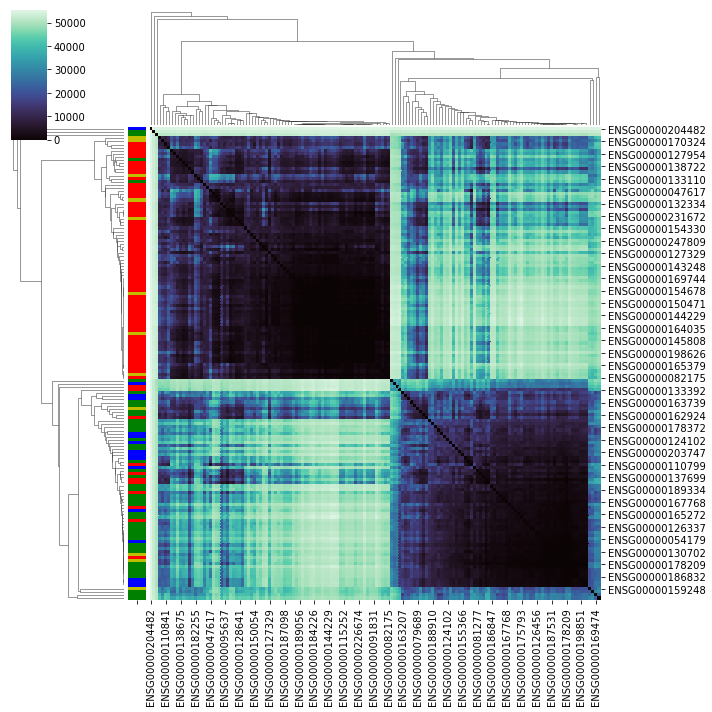

In [1134]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako", row_colors=row_colors)

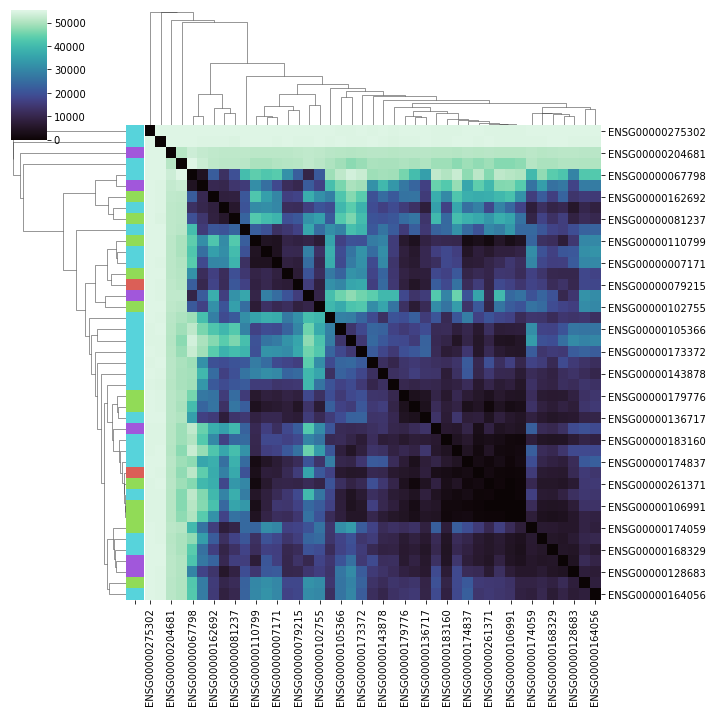

In [288]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako", row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


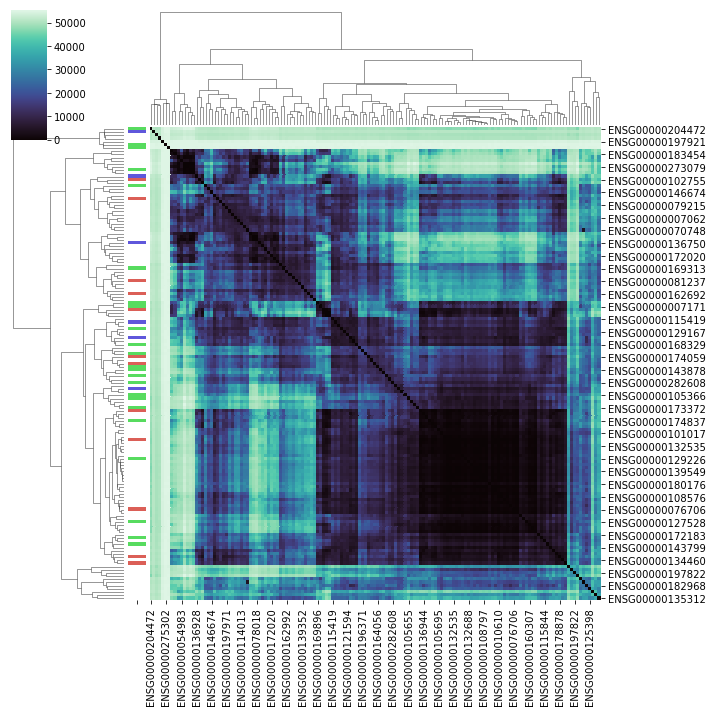

In [273]:
sns.clustermap(df_dist, cmap="mako", row_colors=row_colors)

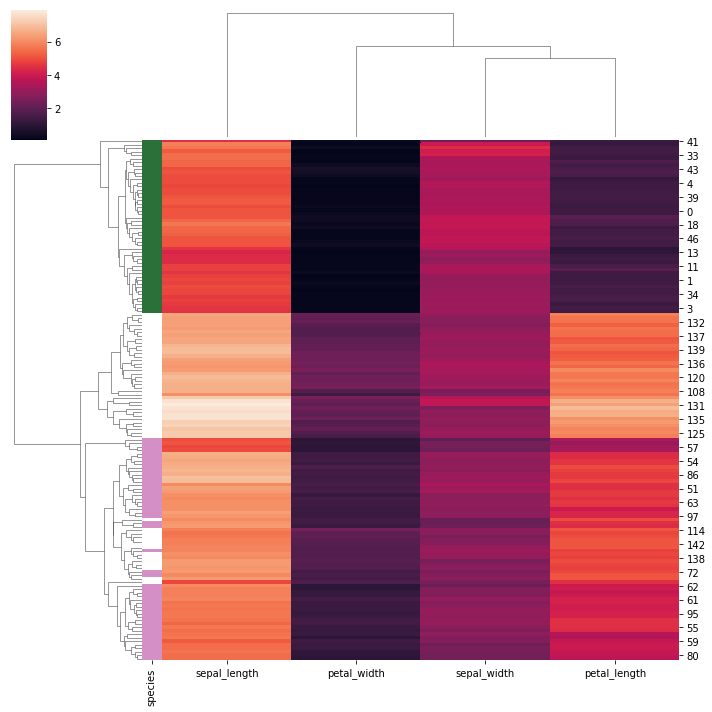

In [173]:
lut = dict(zip(species.unique(), sns.color_palette("cubehelix", 2)))
row_colors = species.map(lut)
g = sns.clustermap(iris, row_colors=row_colors)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


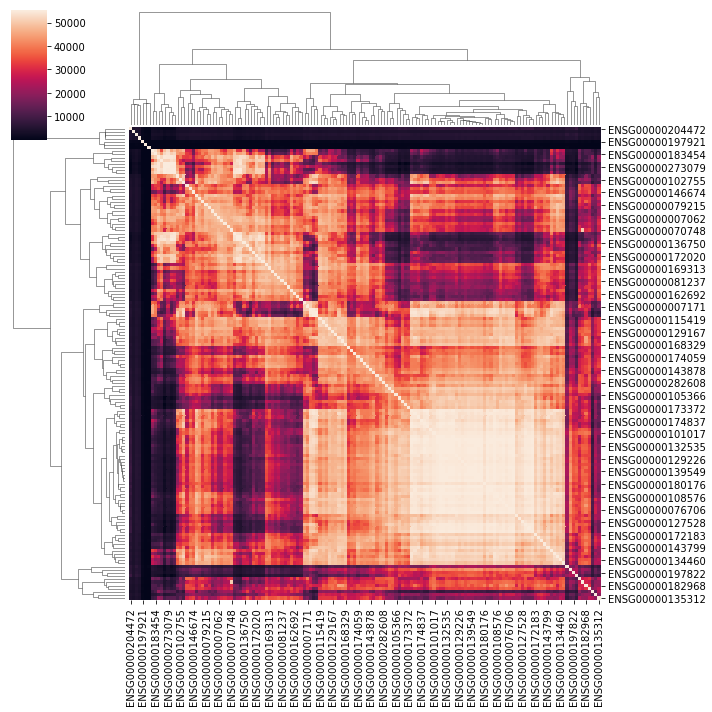

In [142]:
sns.clustermap(nw)

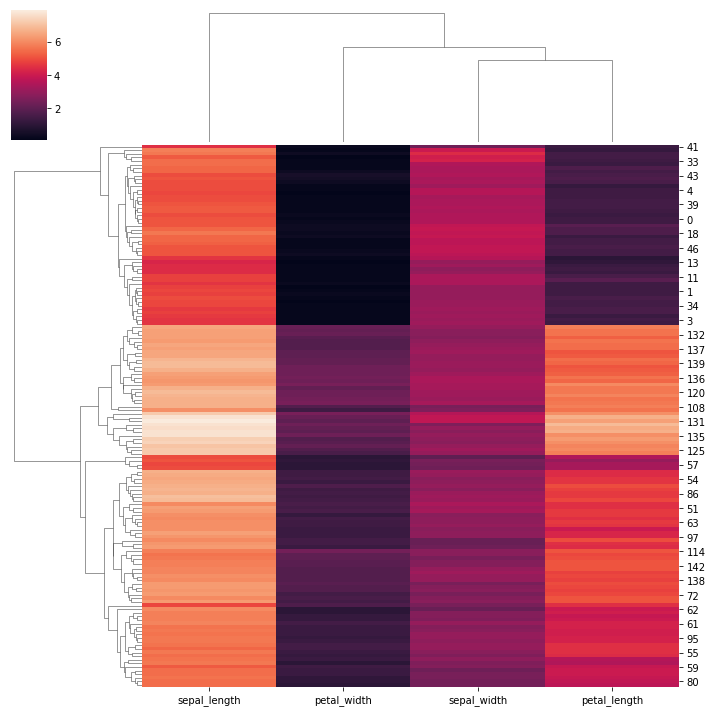

In [140]:
sns.clustermap(iris)

In [287]:
df_dist = nw.max().max()-nw
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-287-e3971396f9ad>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


In [271]:
df_dist = nw.max().max()-nw
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-271-e3971396f9ad>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


In [134]:
linkage_dist.shape

(148, 4)

In [137]:
linkage_dist

array([[7.00000000e+00, 4.10000000e+01, 2.32353684e+00, 2.00000000e+00],
       [9.70000000e+01, 1.01000000e+02, 3.02769306e+00, 2.00000000e+00],
       [2.00000000e+01, 1.50000000e+02, 8.64580138e+00, 3.00000000e+00],
       [4.30000000e+01, 1.51000000e+02, 1.53327709e+01, 4.00000000e+00],
       [3.70000000e+01, 1.05000000e+02, 2.92739258e+01, 2.00000000e+00],
       [1.52000000e+02, 1.53000000e+02, 4.59522658e+01, 6.00000000e+00],
       [9.40000000e+01, 1.49000000e+02, 4.67355850e+01, 3.00000000e+00],
       [7.30000000e+01, 1.30000000e+02, 6.33607316e+01, 2.00000000e+00],
       [1.27000000e+02, 1.54000000e+02, 7.23027167e+01, 7.00000000e+00],
       [9.30000000e+01, 1.13000000e+02, 8.10989064e+01, 2.00000000e+00],
       [1.00000000e+02, 1.57000000e+02, 9.79971344e+01, 8.00000000e+00],
       [1.56000000e+02, 1.59000000e+02, 1.08941918e+02, 1.00000000e+01],
       [8.40000000e+01, 1.60000000e+02, 1.31024430e+02, 1.10000000e+01],
       [5.50000000e+01, 1.18000000e+02, 1.34268981e

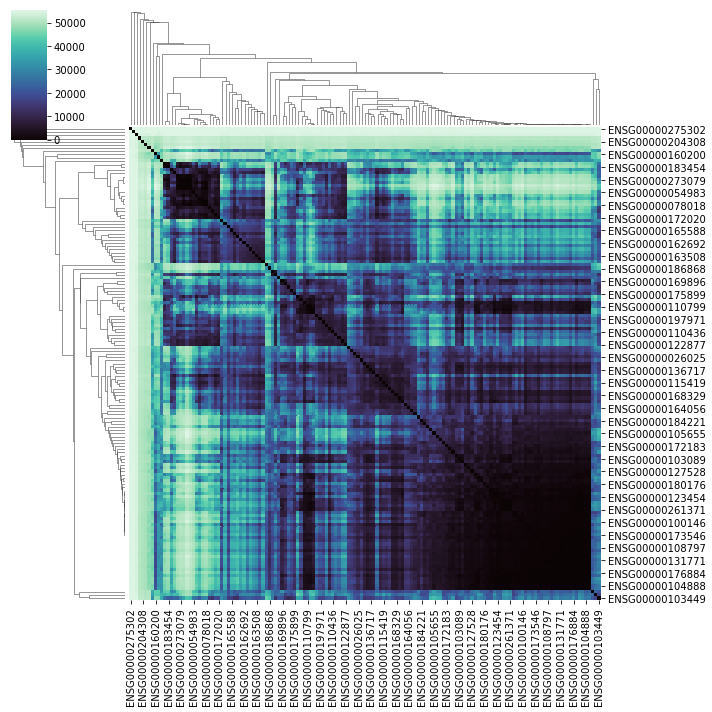

In [127]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako")

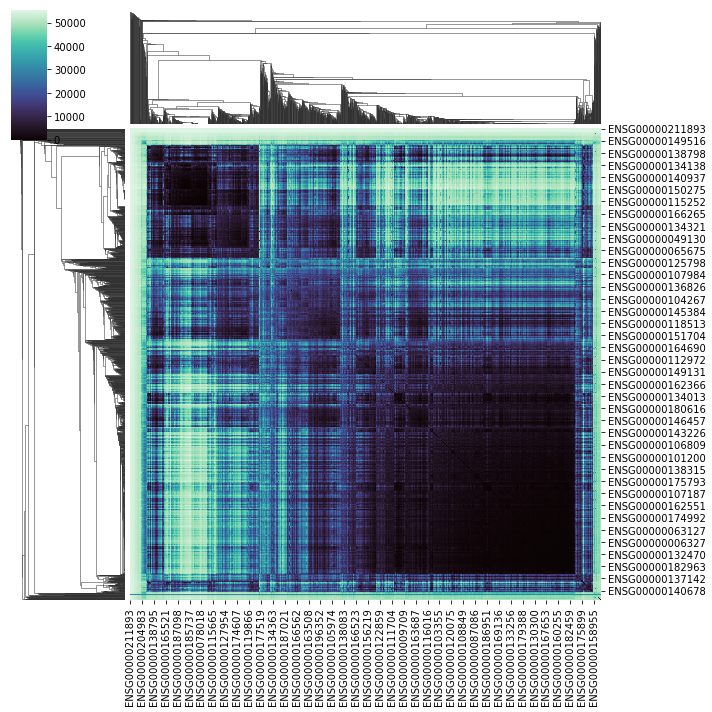

In [100]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako")

In [91]:
linkage_jac = hc.linkage(sp.distance.squareform(nw), method='average')

ValueError: Distance matrix 'X' diagonal must be zero.

In [81]:
df_jac_corr.max().max()

55410.54265398567

In [61]:
df_2d_jac[df_2d_jac['AUC'] > 0.7]

AUC  AVG_NODE_DEGREE  \
Immune system--T cells                            0.705926     6.818596e+07   
Immune system-Non-classical monocytes             0.751511     6.229179e+07   
Immune system-Intermediate monocytes              0.749089     6.956012e+07   
Eye-GABAergic amacrine cells                      0.725118     5.719714e+07   
Eye-Glycinergic amacrine cells                    0.713060     5.625850e+07   
Eye-Cholinergic GABAergic amacrine cells          0.713126     5.867519e+07   
Eye-Tachykinin GABAergic amacrine cells           0.713126     5.867519e+07   
Eye-Starburst amacrine cells                      0.705281     5.927721e+07   
Kidney-Immune cells                               0.702944     5.436364e+07   
Gastrointestinal tract-Goblet cells               0.703677     6.033314e+07   
Skin-Keratinocytes                                0.725577     6.409354e+07   
White adipose tissue-Adipocytes                   0.794001     5.635899e+07   
White adipose tissue-Smooth Muscle cells          0.780879     4.922377e+07   
White adipose tissue-Pericytes                    0.926933     4.663613e+07   
White adipose tissue-Endothelial cells            0.857126     5.055738e+07   
White adipose tissue-Lymphatic Endothelial cells  0.848315     5.477354e+07   
White adipose tissue-Endometrium                  0.955263     4.448853e+07   

                                                  DEGREE_NULL_AUC  \
Immune system--T cells                                   0.603222   
Immune system-Non-classical monocytes                    0.493370   
Immune system-Intermediate monocytes                     0.592135   
Eye-GABAergic amacrine cells                             0.345058   
Eye-Glycinergic amacrine cells                           0.326630   
Eye-Cholinergic GABAergic amacrine cells                 0.382071   
Eye-Tachykinin GABAergic amacrine cells                  0.382071   
Eye-Starburst amacrine cells                             0.388386   
Kidney-Immune cells                                      0.416660   
Gastrointestinal tract-Goblet cells                      0.499639   
Skin-Keratinocytes                                       0.513763   
White adipose tissue-Adipocytes                          0.349302   
White adipose tissue-Smooth Muscle cells                 0.252456   
White adipose tissue-Pericytes                           0.147855   
White adipose tissue-Endothelial cells                   0.254782   
White adipose tissue-Lymphatic Endothelial cells         0.282376   
White adipose tissue-Endometrium                         0.118189   

                                                       P_Value  
Immune system--T cells                            4.045537e-03  
Immune system-Non-classical monocytes             3.001598e-04  
Immune system-Intermediate monocytes              2.058223e-03  
Eye-GABAergic amacrine cells                      4.479939e-03  
Eye-Glycinergic amacrine cells                    3.496909e-03  
Eye-Cholinergic GABAergic amacrine cells          5.076309e-03  
Eye-Tachykinin GABAergic amacrine cells           5.076309e-03  
Eye-Starburst amacrine cells                      2.489675e-03  
Kidney-Immune cells                               3.555981e-06  
Gastrointestinal tract-Goblet cells               8.271379e-05  
Skin-Keratinocytes                                7.796867e-08  
White adipose tissue-Adipocytes                   1.561683e-03  
White adipose tissue-Smooth Muscle cells          4.737278e-04  
White adipose tissue-Pericytes                    1.812569e-07  
White adipose tissue-Endothelial cells            1.262235e-06  
White adipose tissue-Lymphatic Endothelial cells  1.762053e-07  
White adipose tissue-Endometrium                  1.401306e-07

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

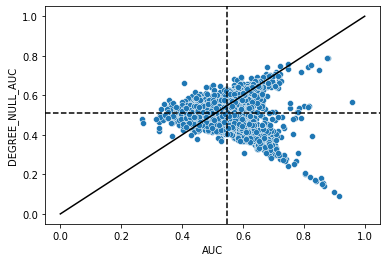

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [20]:
df_gene_performance.sort_values(by=['auc'])

gene_id_jac_sim chrom_jac_sim gene_id_exp_file chrom_exp_file       auc
20315  ENSG00000205078         chr16  ENSG00000205078          chr16  0.170762
4629   ENSG00000152117          chr2  ENSG00000152117           chr2  0.192377
21978  ENSG00000163040          chr2  ENSG00000163040           chr2  0.194299
22970  ENSG00000173272          chr2  ENSG00000173272           chr2  0.196486
6948   ENSG00000179611         chr13  ENSG00000179611          chr13  0.199130
...                ...           ...              ...            ...       ...
12263  ENSG00000184524         chr11  ENSG00000184524          chr11  0.871896
919    ENSG00000184986         chr14  ENSG00000184986          chr14  0.871934
4115   ENSG00000170638         chr22  ENSG00000170638          chr22  0.875262
6094   ENSG00000185347         chr14  ENSG00000185347          chr14  0.879832
5418   ENSG00000184916         chr14  ENSG00000184916          chr14  0.881737

[23465 rows x 5 columns]

In [196]:
top_genes = df_gene_performance[df_gene_performance['auc'] > 0.88]['gene_id_jac_sim'].tolist()

In [197]:
len(top_genes)

106

In [28]:
df_2d, go_chrom  = run_egad(go_df, df_jac_corr.loc[top_genes, top_genes])

(95, 95)
(95, 22517)
0.9962147897611863
0.0


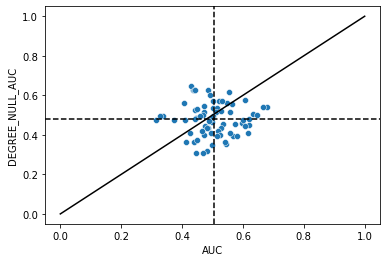

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [33]:
#df_exp = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5")
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path="/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5"

jac_sim = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_exp_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [360]:
df_gene_performance.sort_values(by=['auc'])

gene_id_jac_sim chrom_jac_sim gene_id_exp_file chrom_exp_file       auc
21277  ENSG00000235711         chr15  ENSG00000235711          chr15  0.150237
457    ENSG00000159248         chr15  ENSG00000159248          chr15  0.228787
13566  ENSG00000280551          chr4  ENSG00000280551           chr4  0.233043
4948   ENSG00000111262         chr12  ENSG00000111262          chr12  0.233260
2162   ENSG00000139985         chr14  ENSG00000139985          chr14  0.246263
...                ...           ...              ...            ...       ...
14186  ENSG00000151834          chr4  ENSG00000151834           chr4  0.933023
14811  ENSG00000164796          chr8  ENSG00000164796           chr8  0.940283
17086  ENSG00000152208          chr4  ENSG00000152208           chr4  0.941499
16116  ENSG00000182050         chr12  ENSG00000182050          chr12  0.942104
11620  ENSG00000139915         chr14  ENSG00000139915          chr14  0.945863

[23465 rows x 5 columns]

In [392]:
top_genes = df_gene_performance[df_gene_performance['auc'] > 0.82]['gene_id_jac_sim'].tolist()

In [393]:
df_set_genes = df_gene_performance.set_index('gene_id_jac_sim')[['auc']]

In [394]:
len(top_genes)

3207

In [395]:
df_set_genes['top_100'] = [1 if (x>0.82) else 0 for x in df_set_genes['auc']]

In [386]:
len(df_set_genes[df_set_genes['top_100'] == 1].index.tolist())

4574

In [396]:
df_exp_corr_top_100 = df_exp_corr.loc[df_set_genes[df_set_genes['top_100'] == 1].index.tolist(),df_set_genes[df_set_genes['top_100'] == 1].index.tolist()]



In [397]:
df_jac_corr_top_100 = df_jac_corr.loc[df_set_genes[df_set_genes['top_100'] == 1].index.tolist(),df_set_genes[df_set_genes['top_100'] == 1].index.tolist()]


In [398]:
df_dist_corr_top_100 = df_dist_corr.loc[df_set_genes[df_set_genes['top_100'] == 1].index.tolist(),df_set_genes[df_set_genes['top_100'] == 1].index.tolist()]


In [93]:
df_dist.values

array([[5.71348649e-01, 1.47985634e+03, 1.18064604e+03, ...,
        3.97354862e+04, 5.26117428e+04, 7.96798749e+02],
       [1.47985634e+03, 0.00000000e+00, 2.45613076e+03, ...,
        4.11014000e+04, 5.24867889e+04, 1.77240395e+03],
       [1.18064604e+03, 2.45613076e+03, 5.71348649e-01, ...,
        3.72515901e+04, 5.24766061e+04, 2.25798772e+03],
       ...,
       [3.97354862e+04, 4.11014000e+04, 3.72515901e+04, ...,
        0.00000000e+00, 5.27895955e+04, 4.46688133e+04],
       [5.26117428e+04, 5.24867889e+04, 5.24766061e+04, ...,
        5.27895955e+04, 5.71348649e-01, 5.24231875e+04],
       [7.96798749e+02, 1.77240395e+03, 2.25798772e+03, ...,
        4.46688133e+04, 5.24231875e+04, 0.00000000e+00]])

In [94]:
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0

<ipython-input-94-242e0567a2b7>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


In [96]:
df_dist.values

array([[    0.        ,  1479.85633719,  1180.64603599, ...,
        39735.48615798, 52611.74278573,   796.79874935],
       [ 1479.85633719,     0.        ,  2456.13075924, ...,
        41101.4000379 , 52486.78885961,  1772.40395409],
       [ 1180.64603599,  2456.13075924,     0.        , ...,
        37251.59007237, 52476.60608002,  2257.98771904],
       ...,
       [39735.48615798, 41101.4000379 , 37251.59007237, ...,
            0.        , 52789.59545036, 44668.8132591 ],
       [52611.74278573, 52486.78885961, 52476.60608002, ...,
        52789.59545036,     0.        , 52423.18751692],
       [  796.79874935,  1772.40395409,  2257.98771904, ...,
        44668.8132591 , 52423.18751692,     0.        ]])

In [366]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = df_dist_corr_top_100.max().max()-df_dist_corr_top_100
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_dist = hc.linkage(sp.distance.squareform(df_dist), method='average')


<ipython-input-366-30ee4b93649c>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


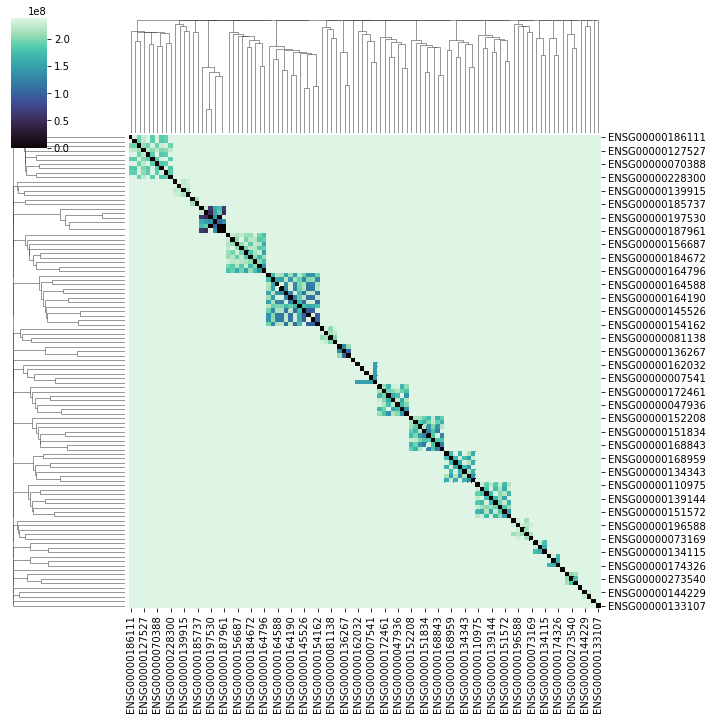

In [367]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako")

In [403]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = df_exp_corr_top_100.max().max()-df_exp_corr_top_100
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_exp = hc.linkage(sp.distance.squareform(df_dist), method='average')


<ipython-input-403-7e01a6e9603c>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


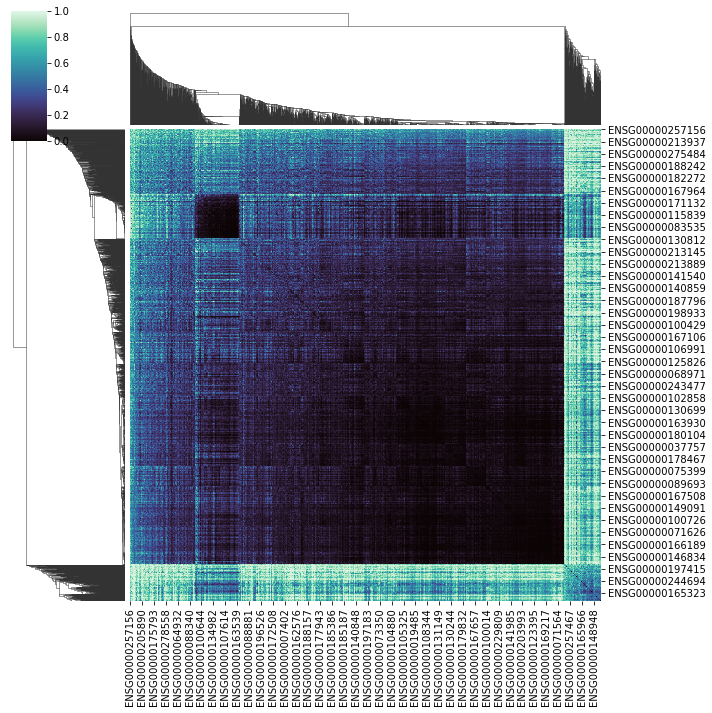

In [404]:
sns.clustermap(df_dist, row_linkage=linkage_exp, col_linkage=linkage_exp, cmap="mako")

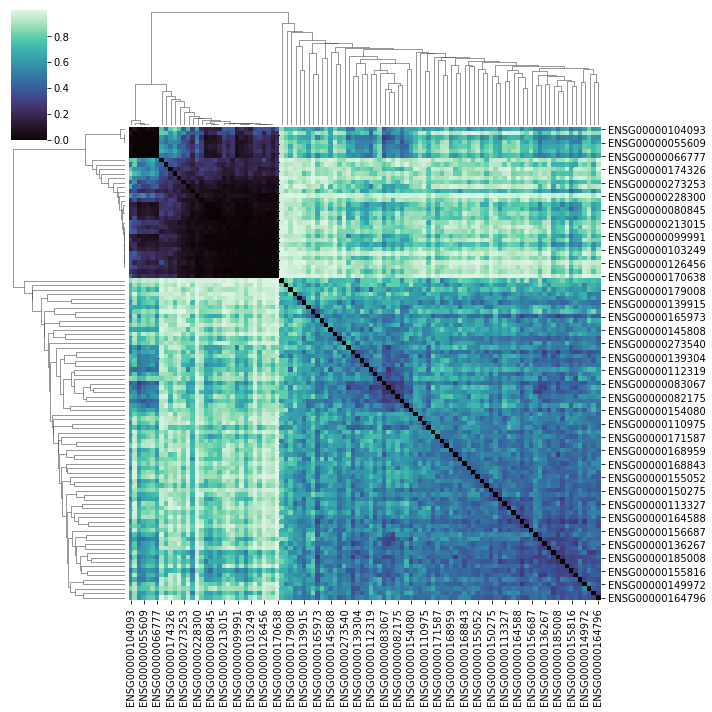

In [362]:
sns.clustermap(df_dist, row_linkage=linkage_exp, col_linkage=linkage_exp, cmap="mako")

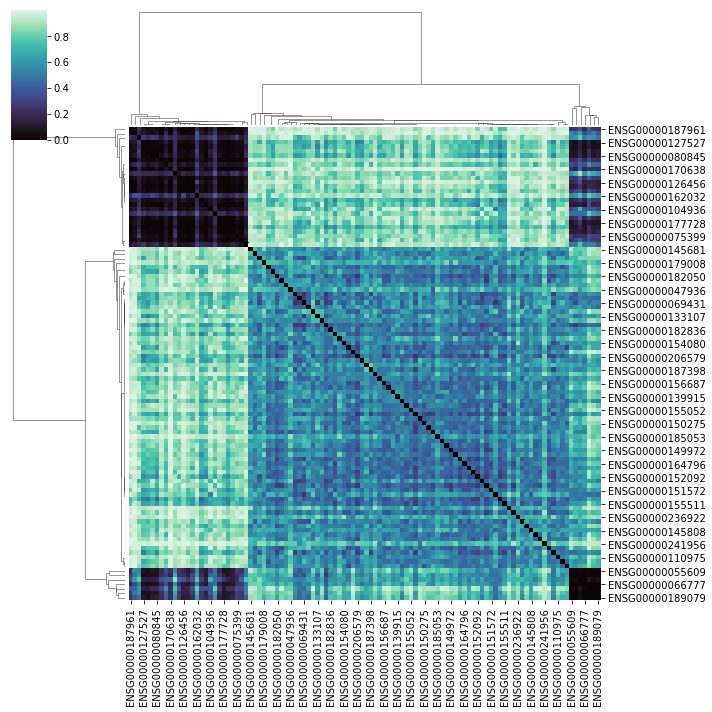

In [377]:
sns.clustermap(df_dist, row_linkage=linkage_jac, col_linkage=linkage_jac, cmap="mako")

In [405]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = df_jac_corr_top_100.max().max()-df_jac_corr_top_100
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_jac = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-405-4a18a8903c43>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


In [323]:
np.fill_diagonal(rank_norm_hic, 0)

In [324]:
linkage_jac = hc.linkage(sp.distance.squareform(rank_norm_hic), method='average')

In [315]:
    L=df_dist.shape[0]

    rank_norm_hic = stats.rankdata(df_dist.values).reshape(L, L)

    #return_matrix = sparse.csr_matrix(rank_norm_hic)

In [316]:
rank_norm_hic  = rank_norm_hic  / np.amax(rank_norm_hic)

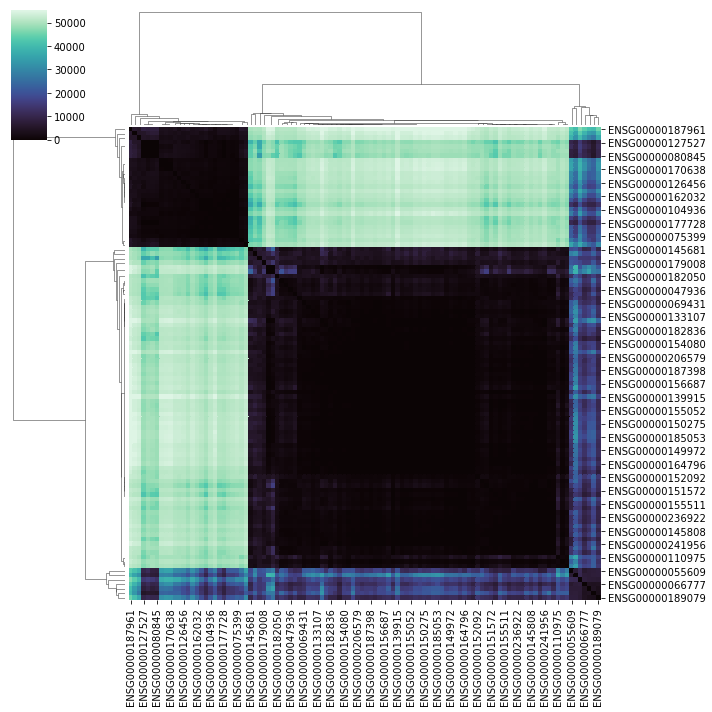

In [375]:
sns.clustermap(df_dist, row_linkage=linkage_jac, col_linkage=linkage_jac, cmap="mako")

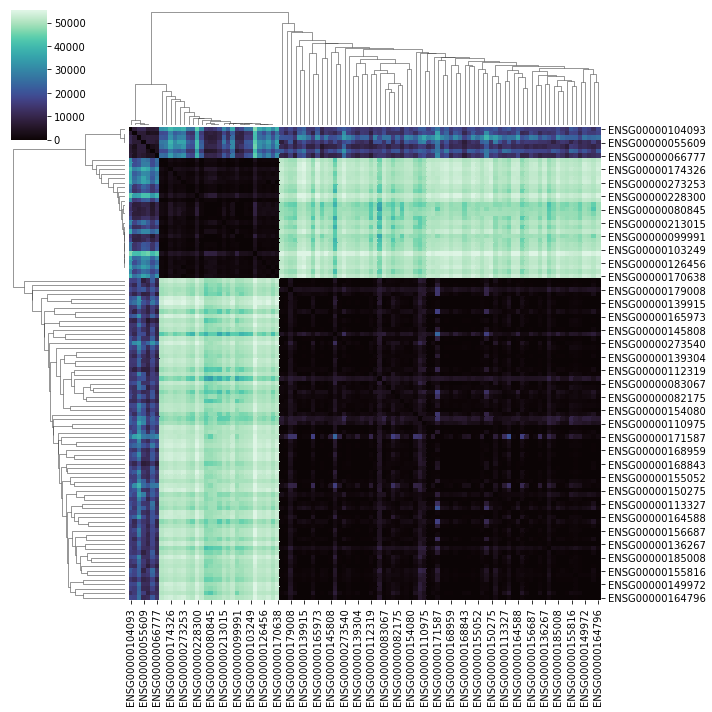

In [371]:
sns.clustermap(df_dist, row_linkage=linkage_exp, col_linkage=linkage_exp, cmap="mako")

In [ ]:
sns.clustermap(df_dist, row_linkage=linkage_exp, col_linkage=linkage_exp, cmap="mako")

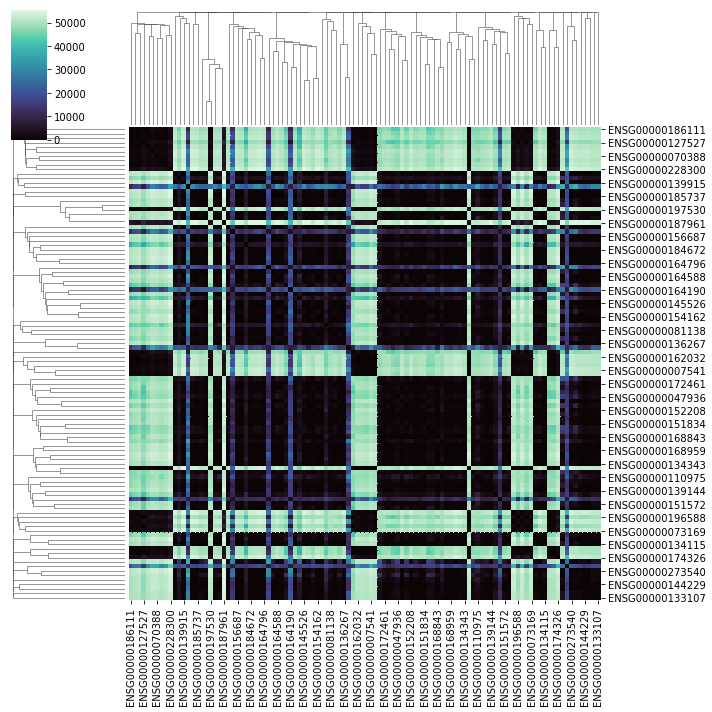

In [373]:
sns.clustermap(df_dist, row_linkage=linkage_dist, col_linkage=linkage_dist, cmap="mako")

In [209]:
set(df_jac_corr_top_100.to_numpy().diagonal())

{55409.81976502861, 55409.97130533649, 55410.54265398567}

In [401]:
df_exp_corr

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000155959         0.276849         0.040029         0.130469   
ENSG00000155961         0.128407         0.128214         0.097678   
ENSG00000155962         0.073441         0.152424         0.278535   
ENSG00000224533         0.334817         0.349970         0.296989   
ENSG00000185973         0.401233         0.185124         0.287707   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         1.000000         0.833857         0.110389   
ENSG00000241860         0.833857         1.000000         0.083856   
...                          ...              ...              ...   
ENSG00000155959         0.077081         0.316597         0.176820   
ENSG00000155961         0.141587         0.323042         0.130175   
ENSG00000155962         0.298601         0.382400         0.077759   
ENSG00000224533         0.386713         0.498483         0.235486   
ENSG00000185973         0.322068         0.724452         0.291270   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000155959         0.678122         0.712112         0.395085   
ENSG00000155961         0.521158         0.579213         0.386790   
ENSG00000155962         0.585610         0.620367         0.564975   
ENSG00000224533         0.667091         0.538497         0.702738   
ENSG00000185973         0.626955         0.728197         0.779498   

                 ENSG00000225972  ...  ENSG00000185010  ENSG00000277203  \
ENSG00000278267         0.208983  ...         0.164307         0.385439   
ENSG00000233750         0.018238  ...         0.036482         0.231122   
ENSG00000268903         0.194718  ...         0.150049         0.649567   
ENSG00000269981         0.067739  ...         0.280591         0.514719   
ENSG00000241860         0.002976  ...         0.433731         0.334044   
...                          ...  ...              ...              ...   
ENSG00000155959         0.093009  ...         0.932798         0.870960   
ENSG00000155961         0.009413  ...         0.772858         0.644082   
ENSG00000155962         0.093091  ...         0.919599         0.646647   
ENSG00000224533         0.010708  ...         0.564739         0.443018   
ENSG00000185973         0.023739  ...         0.924385         0.664635   

                 ENSG00000165775  ENSG00000214827  ENSG00000185515  \
ENSG00000278267         0.298960         0.589250         0.373065   
ENSG00000233750         0.019885         0.179310         0.108605   
ENSG00000268903         0.146318         0.243782         0.220238   
ENSG00000269981         0.059280         0.163406         0.248240   
ENSG00000241860         0.145356         0.526769         0.550166   
...                          ...              ...              ...   
ENSG00000155959         0.999166         0.911992         0.999719   
ENSG00000155961         0.740986 

In [402]:
3000/ 24243

0.12374706100730108

<AxesSubplot:>

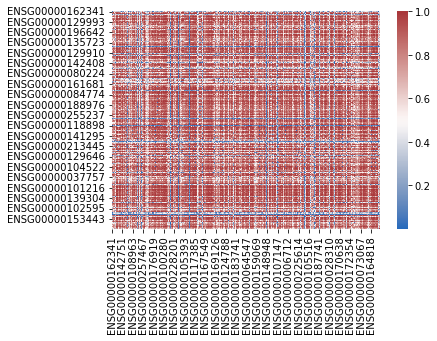

In [399]:
sns.heatmap(df_exp_corr_top_100, cmap="vlag")

<AxesSubplot:>

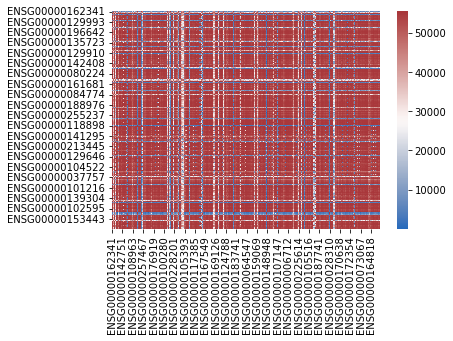

In [400]:
sns.heatmap(df_jac_corr_top_100, cmap="vlag")

<AxesSubplot:>

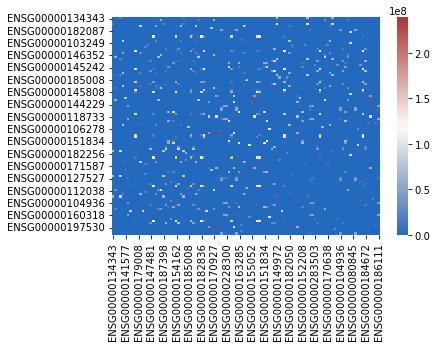

In [358]:
sns.heatmap(df_dist_corr_top_100, cmap="vlag")

In [136]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000227232     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000278267     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000243485     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000284332     6.577371e+06  ...     5.432736e+06     5.432736e+06   
...                          ...  ...              ...              ...   
ENSG00000100312     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000254499     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000213683     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000184319     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000079974     5.432736e+06  ...     6.577492e+06     6.577492e+06   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000227232     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000278267     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000243485     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000284332     5.432736e+06     5.432736e+06     5.432736e+06   
...                          ...              ...              ...   
ENSG00000100312     6.577492e+06     6.577492e+06     6.577492e+06   
ENSG00000254499     6.577492e+06 

In [126]:
df_exp_corr

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000155959         0.276849         0.040029         0.130469   
ENSG00000155961         0.128407         0.128214         0.097678   
ENSG00000155962         0.073441         0.152424         0.278535   
ENSG00000224533         0.334817         0.349970         0.296989   
ENSG00000185973         0.401233         0.185124         0.287707   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         1.000000         0.833857         0.110389   
ENSG00000241860         0.833857         1.000000         0.083856   
...                          ...              ...              ...   
ENSG00000155959         0.077081         0.316597         0.176820   
ENSG00000155961         0.141587         0.323042         0.130175   
ENSG00000155962         0.298601         0.382400         0.077759   
ENSG00000224533         0.386713         0.498483         0.235486   
ENSG00000185973         0.322068         0.724452         0.291270   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000155959         0.678122         0.712112         0.395085   
ENSG00000155961         0.521158         0.579213         0.386790   
ENSG00000155962         0.585610         0.620367         0.564975   
ENSG00000224533         0.667091         0.538497         0.702738   
ENSG00000185973         0.626955         0.728197         0.779498   

                 ENSG00000225972  ...  ENSG00000185010  ENSG00000277203  \
ENSG00000278267         0.208983  ...         0.164307         0.385439   
ENSG00000233750         0.018238  ...         0.036482         0.231122   
ENSG00000268903         0.194718  ...         0.150049         0.649567   
ENSG00000269981         0.067739  ...         0.280591         0.514719   
ENSG00000241860         0.002976  ...         0.433731         0.334044   
...                          ...  ...              ...              ...   
ENSG00000155959         0.093009  ...         0.932798         0.870960   
ENSG00000155961         0.009413  ...         0.772858         0.644082   
ENSG00000155962         0.093091  ...         0.919599         0.646647   
ENSG00000224533         0.010708  ...         0.564739         0.443018   
ENSG00000185973         0.023739  ...         0.924385         0.664635   

                 ENSG00000165775  ENSG00000214827  ENSG00000185515  \
ENSG00000278267         0.298960         0.589250         0.373065   
ENSG00000233750         0.019885         0.179310         0.108605   
ENSG00000268903         0.146318         0.243782         0.220238   
ENSG00000269981         0.059280         0.163406         0.248240   
ENSG00000241860         0.145356         0.526769         0.550166   
...                          ...              ...              ...   
ENSG00000155959         0.999166         0.911992         0.999719   
ENSG00000155961         0.740986 

(23465, 23465)
(23465, 2)
0.4977413168548903
0.0


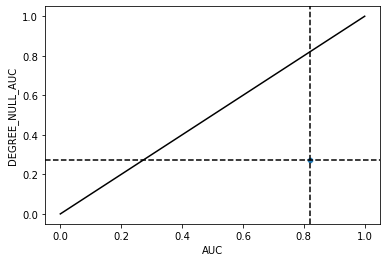

In [210]:
df_2d, go_chrom  = run_egad(df_set_genes, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [99]:
df_2d['AUC']

top_100    0.889622
Name: AUC, dtype: float64

In [62]:
df_2d['AUC']

top_100    0.874008
Name: AUC, dtype: float64

(23465, 23465)
(23465, 2)
0.4977413168548903
0.0


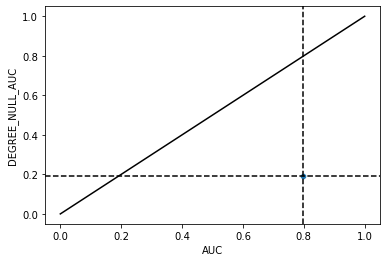

In [211]:
df_2d, go_chrom  = run_egad(df_set_genes, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [101]:
df_2d['AUC']

top_100    0.927439
Name: AUC, dtype: float64

In [173]:
df_2d['AUC']

top_100    0.927439
Name: AUC, dtype: float64

In [53]:
df_2d['AUC']

top_100    0.868081
Name: AUC, dtype: float64

(98, 98)
(98, 22517)
0.9952416904053445
0.0


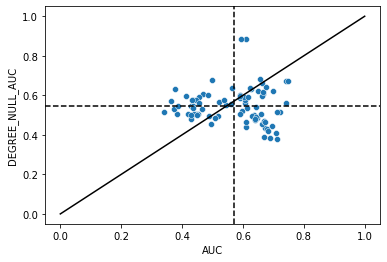

In [378]:
df_2d, go_chrom  = run_egad(go_df, df_jac_corr_top_100)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

(98, 98)
(98, 22517)
0.9952416904053445
0.0


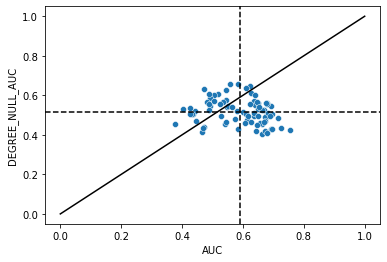

In [379]:
df_2d, go_chrom  = run_egad(go_df, df_exp_corr_top_100)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [381]:
df_2d.sort_values(['AUC'])

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
GO:0051239  0.376031        37.325197         0.454545  0.033207
GO:0051716  0.404031        38.175751         0.530233  0.030151
GO:0007166  0.424908        38.387716         0.537725  0.118729
GO:0046872  0.425589        38.272470         0.504348  0.158989
GO:0043169  0.432522        38.272470         0.504348  0.138336
...              ...              ...              ...       ...
GO:0071704  0.695240        36.829517         0.429466  0.000423
GO:0048856  0.696054        37.937046         0.503129  0.000030
GO:0031224  0.713682        37.791004         0.483526  0.000003
GO:0005887  0.725976        36.841540         0.432995  0.000156
GO:0031226  0.754276        36.787899         0.426187  0.000011

[84 rows x 4 columns]

In [ ]:
df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')